In this notebook we build a model designed to learn the one-step dynamics of our latent space. This model will process an input sequence with a feedforward encoder (such as the ones we trained in phase 1) and give the reduced-dimension sequence to a vanilla RNN as input. The output of the RNN will be fed through the matching feedforward decoder (e.g. the second half of the trained phase 1 model), and the target sequence will be the one-step shifted version of the input sequence.

If trained successfully, the RNN will learn the one-step dynamics of the latent space which our data is projected into and out of with the feedforward encoder and decoder on either side of the RNN.

# Phase 2: One-step dynamical RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

In [2]:
with open('../pytorch_experiments/binary_spike_matrix_data/all_trial_data_BINNED_715093703_11_30_50.npy', 'rb') as f:
    spikes = np.load(f, allow_pickle=True)

In [3]:
spikes.shape

(487, 131, 2001)

## Dataset object

*Sequence to next-step sequence*

In [4]:
class SequenceDataset(TensorDataset):
    '''
    Dataset object for the sequence format of our data that
    will be used with recurrent networks. Right now we'll use each trial as
    a single sample, but we can chop the trials into smaller subsequences
    if that would help with convergence.
    '''
    def __init__(self, data_tensor):
        # we'll pass the data to the RNN in the shape (batch, seq. length, seq. dimension)
        self.data_tensor = data_tensor.permute(0,2,1)
        # storing the number of trials included
        self.trials = data_tensor.shape[0]
        
    def __len__(self):
        return self.trials

    def __getitem__(self, index):
        # times 0-2000 are the input sequence...
        data = self.data_tensor[index, :-1, :]
        # ... and the target sequence is samples 1-2001
        label = self.data_tensor[index, 1:, :]
        return data, label

In [5]:
seq_dataset = SequenceDataset(torch.from_numpy(spikes).float())

seq_loader = DataLoader(seq_dataset, batch_size=1, shuffle=True)

In [6]:
sample = next(iter(seq_loader))
# data
print(sample[0].shape)
# label
print(sample[1].shape)

torch.Size([1, 2000, 131])
torch.Size([1, 2000, 131])


## Model class

In [7]:
class RNN_nextstep(nn.Module):
    '''
    RNN next-step predictor. The FFW encoder and decoder in this model are
    meant to be taken from our Phase 1 model, so we'll specify the same shape
    for those sections as are found in our 3-layer FFW autoencoders.
    
    Input parameters: input_size (the input data dimension), M (the embedding
    dimension, a.k.a. the bottleneck dimension from Phase 1)
    '''
    def __init__(self, input_size, M, num_layers=1):
        super().__init__()
        enc_hidden_size_1 = int((2/3)*input_size + (1/3)*M)
        enc_hidden_size_2 = int((1/3)*input_size + (2/3)*M)
        dec_hidden_size_1 = int((1/3)*input_size + (2/3)*M)
        dec_hidden_size_2 = int((2/3)*input_size + (1/3)*M)
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, enc_hidden_size_1, bias=True),
            nn.Tanh(),
            nn.Linear(enc_hidden_size_1, enc_hidden_size_2, bias=True),
            nn.Tanh(),
            nn.Linear(enc_hidden_size_2, M, bias=True),
            nn.Tanh()
        )
        
        self.rnn = nn.RNN(M, M, num_layers, batch_first=True)

        self.decoder = nn.Sequential(
            nn.Linear(M, dec_hidden_size_1, bias=True),
            nn.Tanh(),
            nn.Linear(dec_hidden_size_1, dec_hidden_size_2, bias=True),
            nn.Tanh(),
            nn.Linear(dec_hidden_size_2, input_size, bias=True)
            # no nonlinearity because we use BCEWithLogitsLoss
        )
        
    def forward(self, x):
        embedded_input = self.encoder(x)
        rnn_output, _ = self.rnn(embedded_input)
        output = self.decoder(rnn_output)
        return output

## Training method

In [185]:
def rnn_train(model, bce_weight, custom_dataloader, num_epochs=1, learning_rate=0.0025, store_output=False):
    '''
    RNN training method, designed for next-step prediction network.
    '''
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(bce_weight))
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)
    outputs = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (source, target) in enumerate(custom_dataloader):                
            pred = model(source)
            
            loss = criterion(pred, target)
            optimizer.zero_grad()
            loss.backward()
            
            #Gradient Value Clipping
#             nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            if i % 50 == 49:    # print every 1000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0
            
        if store_output:
                outputs.append((epoch, loss.item(), source, torch.sigmoid(pred)),)
                
    return outputs

In [22]:
rnn = RNN_nextstep(131, 50)
_ = rnn_train(rnn, 50, seq_loader, num_epochs=1, learning_rate=0.0025)

[1,    50] loss: 0.849
[1,   100] loss: 0.827
[1,   150] loss: 0.824
[1,   200] loss: 0.819
[1,   250] loss: 0.794
[1,   300] loss: 0.827
[1,   350] loss: 0.818
[1,   400] loss: 0.829
[1,   450] loss: 0.814


## Initialization procedure

Our idea is that the FFW encoder and decoder will serve as mappings into and out of our latent space, so we'll initialize those subnetworks with the weights from the trained Phase 1 encoder/decoder weights.

As for the RNN layer, we'll initialize the $W_{hh}$ and $W_{ih}$ layers each to be approximately equal to the identity (setting the diagonal to 1 and the off-diagonals approximately to 0). Under this initialization we are saying that the next latent state is an equal combination of the current and previous latent states. We expect that this will start the optimization process in a reasonable part of the decision surface.

***Here we'll instantiate the network that we'll initialize below***

In [9]:
RNN_next_step_predictor = RNN_nextstep(131, 10)

In [10]:
RNN_next_step_predictor

RNN_nextstep(
  (encoder): Sequential(
    (0): Linear(in_features=131, out_features=90, bias=True)
    (1): Tanh()
    (2): Linear(in_features=90, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): Tanh()
  )
  (rnn): RNN(10, 10, batch_first=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=90, bias=True)
    (3): Tanh()
    (4): Linear(in_features=90, out_features=131, bias=True)
  )
)

### Initializing the FFW encoder and decoder:

*To initialize the FFW sections we will retrain the model we want to use and grab the weights from the encoder and decoder*

***Importing the modules from our experimentation files to reinitialize one of our Phase 1 models:***

*We will retrain and use our 3-layer FFW autoencoder model with $\tau=0$, bottleneck dimension of 10, and bce weight of 100:*

In [11]:
import sys  
sys.path.insert(0, '../pytorch_experiments')

# importing necessary modules from our experimentation files
from create_dataloaders import get_binary_dataloader
from models import FFW_Autoencoder, FFW_Autoencoder_v2, FFW_Autoencoder_v3, train
from experiments import run_experiment

In [12]:
dp = '../pytorch_experiments/binary_spike_matrix_data/all_trial_data_BINNED_715093703_11_30_50.npy'
m = 10
w = 100
tau = 0
epochs = 5

model, output = run_experiment(data_path=dp, num_layers=3, bottleneck_dim=m, bce_weight=w, tau=tau, epochs=epochs)

[1,  1000] loss: 0.440
[1,  2000] loss: 0.230
[1,  3000] loss: 0.169
[1,  4000] loss: 0.135
[1,  5000] loss: 0.116
[1,  6000] loss: 0.103
[1,  7000] loss: 0.093
[1,  8000] loss: 0.088
[1,  9000] loss: 0.081
[2,  1000] loss: 0.073
[2,  2000] loss: 0.069
[2,  3000] loss: 0.069
[2,  4000] loss: 0.065
[2,  5000] loss: 0.062
[2,  6000] loss: 0.062
[2,  7000] loss: 0.059
[2,  8000] loss: 0.057
[2,  9000] loss: 0.055
[3,  1000] loss: 0.052
[3,  2000] loss: 0.051
[3,  3000] loss: 0.052
[3,  4000] loss: 0.049
[3,  5000] loss: 0.048
[3,  6000] loss: 0.047
[3,  7000] loss: 0.046
[3,  8000] loss: 0.046
[3,  9000] loss: 0.045
[4,  1000] loss: 0.043
[4,  2000] loss: 0.043
[4,  3000] loss: 0.044
[4,  4000] loss: 0.040
[4,  5000] loss: 0.041
[4,  6000] loss: 0.041
[4,  7000] loss: 0.041
[4,  8000] loss: 0.040
[4,  9000] loss: 0.040
[5,  1000] loss: 0.039
[5,  2000] loss: 0.040
[5,  3000] loss: 0.038
[5,  4000] loss: 0.039
[5,  5000] loss: 0.040
[5,  6000] loss: 0.040
[5,  7000] loss: 0.039
[5,  8000] 

In [13]:
from experiments import calculate_avg_pred_prob

nospike_pred_prob, spike_pred_prob = calculate_avg_pred_prob(model, torch.from_numpy(spikes).float(), tau)
print('model avg. probability for no input spike',str(nospike_pred_prob),str(type(nospike_pred_prob)))
print('model avg. probability for input spike',str(spike_pred_prob),str(type(spike_pred_prob)))

model avg. probability for no input spike 0.0298234224319458 <class 'float'>
model avg. probability for input spike 0.9910503029823303 <class 'float'>


In [14]:
model

FFW_Autoencoder_v3(
  (encoder): Sequential(
    (0): Linear(in_features=131, out_features=90, bias=True)
    (1): Tanh()
    (2): Linear(in_features=90, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=90, bias=True)
    (3): Tanh()
    (4): Linear(in_features=90, out_features=131, bias=True)
  )
)

***Assigning the FFW weights to the RNN encoder and decoder sections***

In [15]:
with torch.no_grad():
    # assigning the encoder weights
    RNN_next_step_predictor.encoder[0].weight = model.encoder[0].weight
    RNN_next_step_predictor.encoder[0].bias = model.encoder[0].bias
    RNN_next_step_predictor.encoder[2].weight = model.encoder[2].weight
    RNN_next_step_predictor.encoder[2].bias = model.encoder[2].bias
    RNN_next_step_predictor.encoder[4].weight = model.encoder[4].weight
    RNN_next_step_predictor.encoder[4].bias = model.encoder[4].bias
    # assigning the decoder weights
    RNN_next_step_predictor.decoder[0].weight = model.decoder[0].weight
    RNN_next_step_predictor.decoder[0].bias = model.decoder[0].bias
    RNN_next_step_predictor.decoder[2].weight = model.decoder[2].weight
    RNN_next_step_predictor.decoder[2].bias = model.decoder[2].bias
    RNN_next_step_predictor.decoder[4].weight = model.decoder[4].weight
    RNN_next_step_predictor.decoder[4].bias = model.decoder[4].bias

### Initializing the RNN layer

In [16]:
print(RNN_next_step_predictor.rnn.weight_ih_l0.shape)
print(RNN_next_step_predictor.rnn.weight_hh_l0.shape)

torch.Size([10, 10])
torch.Size([10, 10])


*Let's define our two $I+\epsilon$ matrices that we'll put into the RNN layer*

In [17]:
# create empty tensors
w_ih = torch.empty(10,10)
w_hh = torch.empty(10,10)

# initialize them with the identity
nn.init.eye_(w_ih)
nn.init.eye_(w_hh)

# add low-magnitude random noise to avoid issues with zero-gradients
w_ih = w_ih + (0.01)*torch.randn(10,10)
w_hh = w_hh + (0.01)*torch.randn(10,10)

# assign these to the weights in the RNN layer
with torch.no_grad():
    RNN_next_step_predictor.rnn.weight_ih_l0 = nn.Parameter(w_ih)
    RNN_next_step_predictor.rnn.weight_hh_l0 = nn.Parameter(w_hh)

## Training with our initialized network:

***Let's try first training with the weights in the encoder and decoder frozen, so just our RNN will optimize. After giving the RNN a chance to move to in the right direction we will unfreeze and fine tune the encoder and decoder.***

**We freeze layers by setting `requires_grad = False`**

In [18]:
# freezing the encoder
RNN_next_step_predictor.encoder[0].weight.requires_grad = False
RNN_next_step_predictor.encoder[0].bias.requires_grad = False
RNN_next_step_predictor.encoder[2].weight.requires_grad = False
RNN_next_step_predictor.encoder[2].bias.requires_grad = False
RNN_next_step_predictor.encoder[4].weight.requires_grad = False
RNN_next_step_predictor.encoder[4].bias.requires_grad = False
# freezing the decoder
RNN_next_step_predictor.decoder[0].weight.requires_grad = False
RNN_next_step_predictor.decoder[0].bias.requires_grad = False
RNN_next_step_predictor.decoder[2].weight.requires_grad = False
RNN_next_step_predictor.decoder[2].bias.requires_grad = False
RNN_next_step_predictor.decoder[4].weight.requires_grad = False
RNN_next_step_predictor.decoder[4].bias.requires_grad = False

In [19]:
# training for five epochs with the encoder and decoder frozen
_ = rnn_train(RNN_next_step_predictor, 50, seq_loader, num_epochs=5, learning_rate=0.0025)

[1,    50] loss: 8.047
[1,   100] loss: 2.890
[1,   150] loss: 2.309
[1,   200] loss: 2.079
[1,   250] loss: 2.013
[1,   300] loss: 1.991
[1,   350] loss: 1.913
[1,   400] loss: 1.843
[1,   450] loss: 1.828
[2,    50] loss: 1.781
[2,   100] loss: 1.754
[2,   150] loss: 1.751
[2,   200] loss: 1.730
[2,   250] loss: 1.665
[2,   300] loss: 1.687
[2,   350] loss: 1.673
[2,   400] loss: 1.619
[2,   450] loss: 1.607
[3,    50] loss: 1.536
[3,   100] loss: 1.539
[3,   150] loss: 1.490
[3,   200] loss: 1.478
[3,   250] loss: 1.457
[3,   300] loss: 1.433
[3,   350] loss: 1.427
[3,   400] loss: 1.375
[3,   450] loss: 1.382
[4,    50] loss: 1.387
[4,   100] loss: 1.362
[4,   150] loss: 1.371
[4,   200] loss: 1.359
[4,   250] loss: 1.365
[4,   300] loss: 1.350
[4,   350] loss: 1.350
[4,   400] loss: 1.348
[4,   450] loss: 1.350
[5,    50] loss: 1.359
[5,   100] loss: 1.360
[5,   150] loss: 1.363
[5,   200] loss: 1.358
[5,   250] loss: 1.357
[5,   300] loss: 1.333
[5,   350] loss: 1.345
[5,   400] 

*(going to continue this training a little longer)*

In [20]:
_ = rnn_train(RNN_next_step_predictor, 50, seq_loader, num_epochs=5, learning_rate=0.0075)

[1,    50] loss: 1.394
[1,   100] loss: 1.339
[1,   150] loss: 1.353
[1,   200] loss: 1.377
[1,   250] loss: 1.356
[1,   300] loss: 1.361
[1,   350] loss: 1.382
[1,   400] loss: 1.364
[1,   450] loss: 1.376
[2,    50] loss: 1.367
[2,   100] loss: 1.357
[2,   150] loss: 1.368
[2,   200] loss: 1.366
[2,   250] loss: 1.376
[2,   300] loss: 1.362
[2,   350] loss: 1.364
[2,   400] loss: 1.367
[2,   450] loss: 1.363
[3,    50] loss: 1.364


KeyboardInterrupt: 

*Okay, we seem stuck with training just the RNN, although the loss seems higher than it should be. Let's try unfreezing the encoder and decoder and continuing.*

In [21]:
# freezing the encoder
RNN_next_step_predictor.encoder[0].weight.requires_grad = True
RNN_next_step_predictor.encoder[0].bias.requires_grad = True
RNN_next_step_predictor.encoder[2].weight.requires_grad = True
RNN_next_step_predictor.encoder[2].bias.requires_grad = True
RNN_next_step_predictor.encoder[4].weight.requires_grad = True
RNN_next_step_predictor.encoder[4].bias.requires_grad = True
# freezing the decoder
RNN_next_step_predictor.decoder[0].weight.requires_grad = True
RNN_next_step_predictor.decoder[0].bias.requires_grad = True
RNN_next_step_predictor.decoder[2].weight.requires_grad = True
RNN_next_step_predictor.decoder[2].bias.requires_grad = True
RNN_next_step_predictor.decoder[4].weight.requires_grad = True
RNN_next_step_predictor.decoder[4].bias.requires_grad = True

In [22]:
_ = rnn_train(RNN_next_step_predictor, 50, seq_loader, num_epochs=10, learning_rate=0.0025)

[1,    50] loss: 0.908
[1,   100] loss: 0.851
[1,   150] loss: 0.836
[1,   200] loss: 0.841
[1,   250] loss: 0.843
[1,   300] loss: 0.850
[1,   350] loss: 0.815
[1,   400] loss: 0.831
[1,   450] loss: 0.824
[2,    50] loss: 0.823
[2,   100] loss: 0.852
[2,   150] loss: 0.837
[2,   200] loss: 0.813
[2,   250] loss: 0.839
[2,   300] loss: 0.828
[2,   350] loss: 0.816
[2,   400] loss: 0.828
[2,   450] loss: 0.843
[3,    50] loss: 0.848
[3,   100] loss: 0.821
[3,   150] loss: 0.828
[3,   200] loss: 0.809
[3,   250] loss: 0.827
[3,   300] loss: 0.817
[3,   350] loss: 0.834
[3,   400] loss: 0.841
[3,   450] loss: 0.829
[4,    50] loss: 0.829
[4,   100] loss: 0.814
[4,   150] loss: 0.819
[4,   200] loss: 0.832
[4,   250] loss: 0.813
[4,   300] loss: 0.821
[4,   350] loss: 0.823
[4,   400] loss: 0.824
[4,   450] loss: 0.834
[5,    50] loss: 0.837
[5,   100] loss: 0.822
[5,   150] loss: 0.795
[5,   200] loss: 0.838
[5,   250] loss: 0.823
[5,   300] loss: 0.803


KeyboardInterrupt: 

In [23]:
_ = rnn_train(RNN_next_step_predictor, 50, seq_loader, num_epochs=10, learning_rate=0.001)

[1,    50] loss: 0.804
[1,   100] loss: 0.810
[1,   150] loss: 0.800
[1,   200] loss: 0.811
[1,   250] loss: 0.833
[1,   300] loss: 0.819
[1,   350] loss: 0.819
[1,   400] loss: 0.809
[1,   450] loss: 0.814
[2,    50] loss: 0.826
[2,   100] loss: 0.821
[2,   150] loss: 0.803
[2,   200] loss: 0.800
[2,   250] loss: 0.813
[2,   300] loss: 0.811
[2,   350] loss: 0.806
[2,   400] loss: 0.818
[2,   450] loss: 0.803
[3,    50] loss: 0.831
[3,   100] loss: 0.832
[3,   150] loss: 0.803


KeyboardInterrupt: 

## We didn't find well-behaved convergence with our RNN. A simple explanation may be that a 1-layer RNN isn't expressive enough to learn the next-step dynamics of our system. Let's try using a 3-layer RNN in the middle (initialized the same way as our 1-layer RNN)

In [24]:
RNN_three_layer = RNN_nextstep(131, 10, num_layers=3)

In [25]:
RNN_three_layer

RNN_nextstep(
  (encoder): Sequential(
    (0): Linear(in_features=131, out_features=90, bias=True)
    (1): Tanh()
    (2): Linear(in_features=90, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): Tanh()
  )
  (rnn): RNN(10, 10, num_layers=3, batch_first=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=90, bias=True)
    (3): Tanh()
    (4): Linear(in_features=90, out_features=131, bias=True)
  )
)

***Assigning the encoder/decoder weights***

In [26]:
with torch.no_grad():
    # assigning the encoder weights
    RNN_three_layer.encoder[0].weight = model.encoder[0].weight
    RNN_three_layer.encoder[0].bias = model.encoder[0].bias
    RNN_three_layer.encoder[2].weight = model.encoder[2].weight
    RNN_three_layer.encoder[2].bias = model.encoder[2].bias
    RNN_three_layer.encoder[4].weight = model.encoder[4].weight
    RNN_three_layer.encoder[4].bias = model.encoder[4].bias
    # assigning the decoder weights
    RNN_three_layer.decoder[0].weight = model.decoder[0].weight
    RNN_three_layer.decoder[0].bias = model.decoder[0].bias
    RNN_three_layer.decoder[2].weight = model.decoder[2].weight
    RNN_three_layer.decoder[2].bias = model.decoder[2].bias
    RNN_three_layer.decoder[4].weight = model.decoder[4].weight
    RNN_three_layer.decoder[4].bias = model.decoder[4].bias

***Initializing all of the RNN weights***

In [27]:
# create empty tensors
w1_ih = torch.empty(10,10)
w1_hh = torch.empty(10,10)

# initialize them with the identity
nn.init.eye_(w1_ih)
nn.init.eye_(w1_hh)

# add low-magnitude random noise to avoid issues with zero-gradients
# --> we'll get different noise additions for our other two layers
w1_ih = w1_ih + (0.01)*torch.randn(10,10)
w1_hh = w1_hh + (0.01)*torch.randn(10,10)
w2_ih = w1_ih + (0.01)*torch.randn(10,10)
w2_hh = w1_hh + (0.01)*torch.randn(10,10)
w3_ih = w1_ih + (0.01)*torch.randn(10,10)
w3_hh = w1_hh + (0.01)*torch.randn(10,10)


# assign these to the weights in the RNN layer
with torch.no_grad():
    RNN_three_layer.rnn.weight_ih_l0 = nn.Parameter(w1_ih)
    RNN_three_layer.rnn.weight_hh_l0 = nn.Parameter(w1_hh)
    RNN_three_layer.rnn.weight_ih_l1 = nn.Parameter(w2_ih)
    RNN_three_layer.rnn.weight_hh_l1 = nn.Parameter(w2_hh)
    RNN_three_layer.rnn.weight_ih_l2 = nn.Parameter(w3_ih)
    RNN_three_layer.rnn.weight_hh_l2 = nn.Parameter(w3_hh)

***Freeze the encoder and decoder***

In [28]:
# freezing the encoder
RNN_three_layer.encoder[0].weight.requires_grad = False
RNN_three_layer.encoder[0].bias.requires_grad = False
RNN_three_layer.encoder[2].weight.requires_grad = False
RNN_three_layer.encoder[2].bias.requires_grad = False
RNN_three_layer.encoder[4].weight.requires_grad = False
RNN_three_layer.encoder[4].bias.requires_grad = False
# freezing the decoder
RNN_three_layer.decoder[0].weight.requires_grad = False
RNN_three_layer.decoder[0].bias.requires_grad = False
RNN_three_layer.decoder[2].weight.requires_grad = False
RNN_three_layer.decoder[2].bias.requires_grad = False
RNN_three_layer.decoder[4].weight.requires_grad = False
RNN_three_layer.decoder[4].bias.requires_grad = False

***Training just the RNN, see if we get better convergence with 3 RNN layers***

In [29]:
_ = rnn_train(RNN_three_layer, 50, seq_loader, num_epochs=10, learning_rate=0.001)

[1,    50] loss: 3.716
[1,   100] loss: 0.924
[1,   150] loss: 0.866
[1,   200] loss: 0.863
[1,   250] loss: 0.818
[1,   300] loss: 0.830
[1,   350] loss: 0.821
[1,   400] loss: 0.803
[1,   450] loss: 0.816
[2,    50] loss: 0.843
[2,   100] loss: 0.827
[2,   150] loss: 0.795
[2,   200] loss: 0.820
[2,   250] loss: 0.795
[2,   300] loss: 0.807
[2,   350] loss: 0.795
[2,   400] loss: 0.819
[2,   450] loss: 0.833
[3,    50] loss: 0.816
[3,   100] loss: 0.817
[3,   150] loss: 0.784
[3,   200] loss: 0.827


KeyboardInterrupt: 

In [30]:
# UNfreezing the encoder
RNN_three_layer.encoder[0].weight.requires_grad = True
RNN_three_layer.encoder[0].bias.requires_grad = True
RNN_three_layer.encoder[2].weight.requires_grad = True
RNN_three_layer.encoder[2].bias.requires_grad = True
RNN_three_layer.encoder[4].weight.requires_grad = True
RNN_three_layer.encoder[4].bias.requires_grad = True
# UNfreezing the decoder
RNN_three_layer.decoder[0].weight.requires_grad = True
RNN_three_layer.decoder[0].bias.requires_grad = True
RNN_three_layer.decoder[2].weight.requires_grad = True
RNN_three_layer.decoder[2].bias.requires_grad = True
RNN_three_layer.decoder[4].weight.requires_grad = True
RNN_three_layer.decoder[4].bias.requires_grad = True

In [31]:
_ = rnn_train(RNN_three_layer, 50, seq_loader, num_epochs=5, learning_rate=0.001)

[1,    50] loss: 0.829
[1,   100] loss: 0.797
[1,   150] loss: 0.797
[1,   200] loss: 0.781
[1,   250] loss: 0.829
[1,   300] loss: 0.807
[1,   350] loss: 0.823
[1,   400] loss: 0.805
[1,   450] loss: 0.817
[2,    50] loss: 0.834
[2,   100] loss: 0.803
[2,   150] loss: 0.802
[2,   200] loss: 0.828
[2,   250] loss: 0.786
[2,   300] loss: 0.793
[2,   350] loss: 0.830
[2,   400] loss: 0.813
[2,   450] loss: 0.799
[3,    50] loss: 0.810
[3,   100] loss: 0.791
[3,   150] loss: 0.830
[3,   200] loss: 0.794
[3,   250] loss: 0.801
[3,   300] loss: 0.789
[3,   350] loss: 0.812
[3,   400] loss: 0.818
[3,   450] loss: 0.798
[4,    50] loss: 0.801
[4,   100] loss: 0.809
[4,   150] loss: 0.808
[4,   200] loss: 0.805
[4,   250] loss: 0.783
[4,   300] loss: 0.789
[4,   350] loss: 0.816
[4,   400] loss: 0.827
[4,   450] loss: 0.805
[5,    50] loss: 0.811
[5,   100] loss: 0.808
[5,   150] loss: 0.803
[5,   200] loss: 0.808
[5,   250] loss: 0.813
[5,   300] loss: 0.815
[5,   350] loss: 0.793
[5,   400] 

## Model evaluation method suited for this class of model and its data format

The binary cross entropy loss that we use is very susceptible to small offsets in predicted output and target. BCE still optimizes our model in the right way, but the actual model performance might be better than a high loss value might lead one to believe.

To get a better picture of actual model performance we will create an entire processed version of our dataset that will let us compare each groundtruth time sample with our model's prediction of it.

Below we specify this function that will report two aggregate measures: one of average model predicted probability of spike given an input spike, and one of average model predicted probability of spike given *no* input spike.

In [32]:
def calculate_avg_pred_prob_onestep_RNN(model, data):
    '''
    Version of our model assessment function designed for use with the one-step
    prediction RNN.
    
    Assumed that data is given in form (trials, data dim, sequence) so we permute
    the data to put it in RNN format: (trials, sequence, data dim)
    
    This is written under the assumption that each data sample is the length of
    an entire trial – this will have to be changed if we start using subsequences instead
    '''
    rnn_data = torch.from_numpy(data).float().permute(0,2,1)

    # initialize output array
    num_trials = rnn_data.shape[0]
    num_units = rnn_data.shape[2]
    # the number of time samples that will get output prediction from our model
    num_recon_samples = rnn_data.shape[1] - 1
    reconstructed_output = torch.from_numpy(np.zeros((num_trials, num_recon_samples, num_units))).float()

    # the loop to get the reconstructed outputs and populate the output array
    for trial in range(num_trials):
        # because we're only taking one sample per trial (that being the whole trial
        # sequence), we don't have an inner loop here.
        input_sample = rnn_data[trial, :-1, :]

        # now we create a single-sample batch
        single_sample_batch = torch.unsqueeze(input_sample, 0)

        # ... and feed it through our model:
        # (using no_grad() so no gradient gets stored with these outputs)
        with torch.no_grad(): 
            sample_recon = model.forward(single_sample_batch)

        # get rid of the batch_size=1 we'll necessarily have here
        sample_recon = torch.squeeze(sample_recon, dim=0)

        # ... and because we only get one output a trial, we just assign the
        # trial reconstruction to be equal to this model output
        reconstructed_output[trial] = sample_recon
                            
    # our trimmed input then is the original input just without the first time sample
    trimmed_input = np.delete(rnn_data, np.s_[-1:],axis=1)
    
    # keep a separate list of the coord lists for the two cases
    trial_zero_coords = []
    trial_one_coords = []

    for trial in range(num_trials):
        us1, cs1 = np.argwhere(trimmed_input[trial])
        trial_one_coords.append([us1.tolist(), cs1.tolist()])

        us0, cs0 = np.argwhere(trimmed_input[trial] == 0)
        trial_zero_coords.append([us0.tolist(), cs0.tolist()])
        
    # bce_sum = torch.nn.BCELoss(reduction='sum')
    bce_wlogit = torch.nn.BCEWithLogitsLoss(reduction='sum')

    # accumulators for bce under spike and no spike, and for number of spike and no spike samples
    total_bce_nospike = 0
    total_bce_spike = 0
    nospike_samples = 0
    spike_samples = 0

    # iterating over all of the trials
    for trial in range(num_trials):
        # accumulating the total bce variables
        total_bce_nospike += bce_wlogit(reconstructed_output[trial][trial_zero_coords[trial]], trimmed_input[trial][trial_zero_coords[trial]])
        total_bce_spike += bce_wlogit(reconstructed_output[trial][trial_one_coords[trial]], trimmed_input[trial][trial_one_coords[trial]])
        # accumulating the number of samples
        nospike_samples += len(trial_zero_coords[trial][0])
        spike_samples += len(trial_one_coords[trial][0])

    avg_bce_nospike = total_bce_nospike/nospike_samples
    avg_bce_spike = total_bce_spike/spike_samples

    nospike_pred_prob = 1 - np.e**(-1*avg_bce_nospike)
    spike_pred_prob = np.e**(-1*avg_bce_spike)

    return nospike_pred_prob.item(), spike_pred_prob.item()

***Model performance of model with 1-layer RNN***

In [33]:
no_spike_prob, spike_prob = calculate_avg_pred_prob_onestep_RNN(RNN_next_step_predictor, spikes)

In [34]:
print(no_spike_prob)
print(spike_prob)

0.2670198082923889
0.3683473467826843


***Model performance of model with 3-layer RNN***

In [35]:
no_spike_prob_firstrnn, spike_prob_firstrnn = calculate_avg_pred_prob_onestep_RNN(RNN_three_layer, spikes)
print(no_spike_prob_firstrnn)
print(spike_prob_firstrnn)

0.285325825214386
0.3936588764190674


## Inspecting the model output for the 3-layer RNN model

$\hat{p}(s|s) = 0.41, \hat{p}(s|!s) = 0.30$ ***doesn't seem very good. What does the output look like that's getting that measure?***

*Just going to duplicate the part of the model evaluation method above that creates the model output data*

In [36]:
rnn_data = torch.from_numpy(spikes).float().permute(0,2,1)

# initialize output array
num_trials = rnn_data.shape[0]
num_units = rnn_data.shape[2]
# the number of time samples that will get output prediction from our model
num_recon_samples = rnn_data.shape[1] - 1
reconstructed_output = torch.from_numpy(np.zeros((num_trials, num_recon_samples, num_units))).float()

# the loop to get the reconstructed outputs and populate the output array
for trial in range(num_trials):
    # because we're only taking one sample per trial (that being the whole trial
    # sequence), we don't have an inner loop here.
    input_sample = rnn_data[trial, :-1, :]

    # now we create a single-sample batch
    single_sample_batch = torch.unsqueeze(input_sample, 0)

    # ... and feed it through our model:
    # (using no_grad() so no gradient gets stored with these outputs)
    with torch.no_grad(): 
        sample_recon = RNN_three_layer.forward(single_sample_batch)

    # get rid of the batch_size=1 we'll necessarily have here
    sample_recon = torch.squeeze(sample_recon, dim=0)

    # ... and because we only get one output a trial, we just assign the
    # trial reconstruction to be equal to this model output
    reconstructed_output[trial] = sample_recon

In [37]:
reconstructed_output.shape

torch.Size([487, 2000, 131])

In [38]:
trimmed_input = np.delete(rnn_data, np.s_[-1:],axis=1)

In [39]:
trimmed_input.shape

torch.Size([487, 2000, 131])

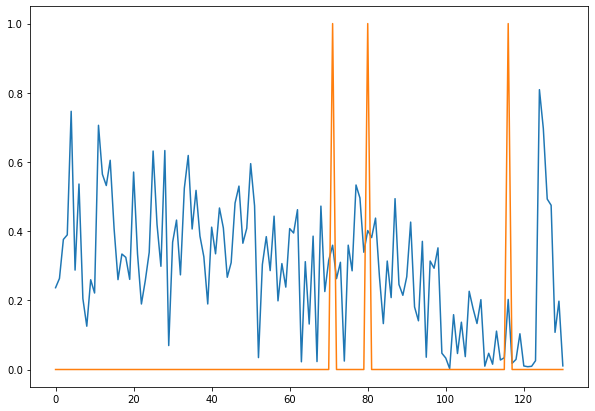

In [40]:
plt.figure(figsize=(10,7))
plt.plot(torch.sigmoid(reconstructed_output[100, 1000]))
plt.plot(trimmed_input[100, 1000])
plt.show()

*Wait, it looks like the RNN is outputting the same predictions for all trial/time pairs...*

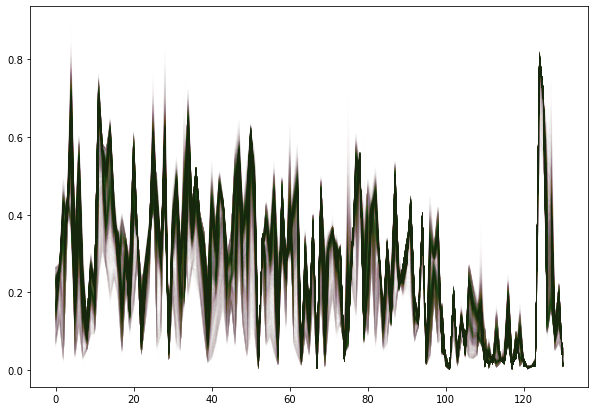

In [41]:
import random

# looking at the distribution of all outputs we get from the RNN
# --> is there any kind of spread on these or are we just always getting the same prediction?
plt.figure(figsize=(10,7))

for trial in range(rnn_data.shape[0]):
    for t in random.sample(range(2000), 10):#range(rnn_data.shape[1]-1):
        plt.plot(torch.sigmoid(reconstructed_output[trial, t]), alpha=0.002)

plt.show()

### Something is wrong with the RNN model: the output at every time point is approximately equal. The model seems to just be learning some nonuniform prior across the channels and predicts that regardless of input.

Below we see that we can pick two random time samples, feed them through our network and get almost the same output

In [42]:
sample_input_1 = torch.reshape(trimmed_input[50, 110], (1,1,131))
sample_input_2 = torch.reshape(trimmed_input[250, 1040], (1,1,131))

# we see that both the 1-layer and the 3-layer model are spitting out a constant output
print(torch.sigmoid(RNN_three_layer(sample_input_1)) - torch.sigmoid(RNN_three_layer(sample_input_2)))
print(torch.sigmoid(RNN_next_step_predictor(sample_input_1)) - torch.sigmoid(RNN_next_step_predictor(sample_input_2)))

tensor([[[-2.9167e-02, -1.0787e-02, -1.4637e-03, -9.3167e-03, -3.5415e-02,
          -1.6217e-02, -1.9691e-02, -5.9848e-02, -1.0945e-02,  2.7710e-03,
          -1.9321e-02, -3.8241e-02, -4.6040e-02, -1.7690e-02, -3.3960e-02,
          -3.4690e-02,  9.7959e-03, -3.8962e-02,  8.9573e-03, -1.1078e-01,
          -2.3936e-02, -4.6746e-03,  1.1049e-03,  1.3174e-03,  2.6068e-03,
          -1.4252e-02, -1.4616e-01, -1.1383e-01, -3.8204e-02, -1.8821e-03,
          -1.1153e-02, -2.5682e-02,  5.0947e-03, -1.0724e-02,  6.8366e-03,
          -4.4313e-03,  6.3618e-03, -3.6329e-02, -2.7586e-02, -4.5570e-02,
          -1.2674e-01, -1.1547e-01,  6.8244e-04,  8.4021e-03, -1.4775e-02,
          -2.6692e-02, -2.1303e-02, -1.8500e-02, -5.5530e-03, -1.9525e-02,
          -3.2624e-03, -1.4945e-02, -3.3139e-03,  1.4964e-03, -4.1981e-02,
          -2.9875e-02, -1.7528e-01, -2.0131e-02,  1.7300e-02, -1.1706e-02,
          -2.2861e-02, -2.9344e-02, -9.7902e-03,  3.0218e-04, -2.2522e-02,
          -1.4088e-02, -1

## Going to initialize a new model and look at the outputs we get after just the first stage of training (when just the RNN is being updated)

In [43]:
rnn_model = RNN_nextstep(131,10,num_layers=3)

In [44]:
with torch.no_grad():
    # assigning the encoder weights
    rnn_model.encoder[0].weight = model.encoder[0].weight
    rnn_model.encoder[0].bias = model.encoder[0].bias
    rnn_model.encoder[2].weight = model.encoder[2].weight
    rnn_model.encoder[2].bias = model.encoder[2].bias
    rnn_model.encoder[4].weight = model.encoder[4].weight
    rnn_model.encoder[4].bias = model.encoder[4].bias
    # assigning the decoder weights
    rnn_model.decoder[0].weight = model.decoder[0].weight
    rnn_model.decoder[0].bias = model.decoder[0].bias
    rnn_model.decoder[2].weight = model.decoder[2].weight
    rnn_model.decoder[2].bias = model.decoder[2].bias
    rnn_model.decoder[4].weight = model.decoder[4].weight
    rnn_model.decoder[4].bias = model.decoder[4].bias

In [45]:
# freezing the encoder
rnn_model.encoder[0].weight.requires_grad = False
rnn_model.encoder[0].bias.requires_grad = False
rnn_model.encoder[2].weight.requires_grad = False
rnn_model.encoder[2].bias.requires_grad = False
rnn_model.encoder[4].weight.requires_grad = False
rnn_model.encoder[4].bias.requires_grad = False
# freezing the decoder
rnn_model.decoder[0].weight.requires_grad = False
rnn_model.decoder[0].bias.requires_grad = False
rnn_model.decoder[2].weight.requires_grad = False
rnn_model.decoder[2].bias.requires_grad = False
rnn_model.decoder[4].weight.requires_grad = False
rnn_model.decoder[4].bias.requires_grad = False

In [46]:
# create empty tensors
w1_ih = torch.empty(10,10)
w1_hh = torch.empty(10,10)

# initialize them with the identity
nn.init.eye_(w1_ih)
nn.init.eye_(w1_hh)

# add low-magnitude random noise to avoid issues with zero-gradients
# --> we'll get different noise additions for our other two layers
w1_ih = w1_ih + (0.01)*torch.randn(10,10)
w1_hh = w1_hh + (0.01)*torch.randn(10,10)
w2_ih = w1_ih + (0.01)*torch.randn(10,10)
w2_hh = w1_hh + (0.01)*torch.randn(10,10)
w3_ih = w1_ih + (0.01)*torch.randn(10,10)
w3_hh = w1_hh + (0.01)*torch.randn(10,10)


# assign these to the weights in the RNN layer
with torch.no_grad():
    rnn_model.rnn.weight_ih_l0 = nn.Parameter(w1_ih)
    rnn_model.rnn.weight_hh_l0 = nn.Parameter(w1_hh)
    rnn_model.rnn.weight_ih_l1 = nn.Parameter(w2_ih)
    rnn_model.rnn.weight_hh_l1 = nn.Parameter(w2_hh)
    rnn_model.rnn.weight_ih_l2 = nn.Parameter(w3_ih)
    rnn_model.rnn.weight_hh_l2 = nn.Parameter(w3_hh)

In [47]:
_ = rnn_train(rnn_model, 50, seq_loader, num_epochs=5, learning_rate=0.001)

[1,    50] loss: 3.974
[1,   100] loss: 0.869
[1,   150] loss: 0.827
[1,   200] loss: 0.815
[1,   250] loss: 0.808
[1,   300] loss: 0.807
[1,   350] loss: 0.820
[1,   400] loss: 0.825
[1,   450] loss: 0.806
[2,    50] loss: 0.823
[2,   100] loss: 0.825
[2,   150] loss: 0.809
[2,   200] loss: 0.813
[2,   250] loss: 0.802
[2,   300] loss: 0.806
[2,   350] loss: 0.818
[2,   400] loss: 0.807
[2,   450] loss: 0.788
[3,    50] loss: 0.824
[3,   100] loss: 0.816
[3,   150] loss: 0.784
[3,   200] loss: 0.826
[3,   250] loss: 0.792
[3,   300] loss: 0.802
[3,   350] loss: 0.802
[3,   400] loss: 0.808
[3,   450] loss: 0.817
[4,    50] loss: 0.818
[4,   100] loss: 0.822
[4,   150] loss: 0.768
[4,   200] loss: 0.787
[4,   250] loss: 0.813
[4,   300] loss: 0.788
[4,   350] loss: 0.833
[4,   400] loss: 0.801
[4,   450] loss: 0.815
[5,    50] loss: 0.818
[5,   100] loss: 0.787
[5,   150] loss: 0.801
[5,   200] loss: 0.810
[5,   250] loss: 0.808
[5,   300] loss: 0.808
[5,   350] loss: 0.821
[5,   400] 

### *Still want to look at the outputs after phase 1 of training*

In [48]:
recon_output_phase1 = torch.from_numpy(np.zeros((num_trials, num_recon_samples, num_units))).float()

# the loop to get the reconstructed outputs and populate the output array
for trial in range(num_trials):
    # because we're only taking one sample per trial (that being the whole trial
    # sequence), we don't have an inner loop here.
    input_sample = rnn_data[trial, :-1, :]

    # now we create a single-sample batch
    single_sample_batch = torch.unsqueeze(input_sample, 0)

    # ... and feed it through our model:
    # (using no_grad() so no gradient gets stored with these outputs)
    with torch.no_grad(): 
        sample_recon = rnn_model.forward(single_sample_batch)

    # get rid of the batch_size=1 we'll necessarily have here
    sample_recon = torch.squeeze(sample_recon, dim=0)

    # ... and because we only get one output a trial, we just assign the
    # trial reconstruction to be equal to this model output
    recon_output_phase1[trial] = sample_recon

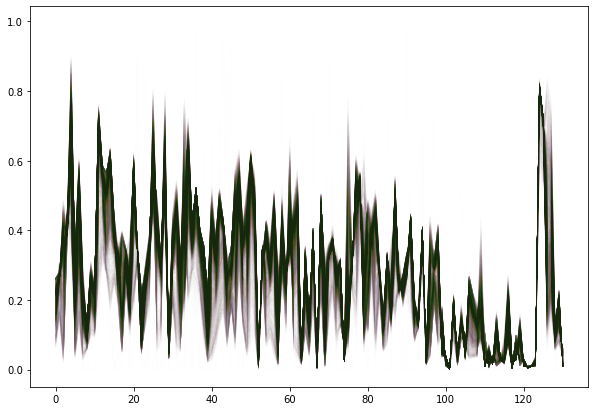

In [49]:
# looking at the distribution of all outputs we get from the RNN
# --> is there any kind of spread on these or are we just always getting the same prediction?
plt.figure(figsize=(10,7))

for trial in range(rnn_data.shape[0]):
    for t in random.sample(range(2000), 10):#range(rnn_data.shape[1]-1):
        plt.plot(torch.sigmoid(recon_output_phase1[trial, t]), alpha=0.002)

plt.show()

## We should write a method to run this check for us in a more rigorous way: *want a method that takes in a model and calculates the variance of each channel's output and judges whether or not the output is ~constant or not*

*Let's check out what kind of variance we have in our sigmoid'ed output from the 3-layer RNN model*

In [50]:
v = torch.var(torch.sigmoid(reconstructed_output), dim=(0,1))

In [51]:
print(max(v).item())
print(np.argmax(v).item())

0.017005586996674538
46


In [78]:
def is_output_constant(model, data):
    '''
    Function to measure a model's output and find whether all channels'
    output has a variance less than or equal to a given threshold
    '''
    # constructing our output array just as in the model eval. method
    rnn_data = torch.from_numpy(data).float().permute(0,2,1)

    num_trials = rnn_data.shape[0]
    num_units = rnn_data.shape[2]
    num_recon_samples = rnn_data.shape[1] - 1
    reconstructed_output = torch.from_numpy(np.zeros((num_trials, num_recon_samples, num_units))).float()

    for trial in range(num_trials):
        input_sample = rnn_data[trial, :-1, :]

        single_sample_batch = torch.unsqueeze(input_sample, 0)

        with torch.no_grad(): 
            sample_recon = model.forward(single_sample_batch)

        sample_recon = torch.squeeze(sample_recon, dim=0)

        reconstructed_output[trial] = sample_recon
    
    sigmoid_output = torch.sigmoid(reconstructed_output)
    # ... and finally we look at the variance along the channel dimension
    v = torch.var(sigmoid_output, dim=(0,1))
    # we'll just return the max variance across all channels, along with the sigmoid'ed output:
    return max(v).item(), sigmoid_output

In [53]:
is_output_constant(RNN_three_layer, spikes)

(True,
 tensor([[[1.6762e-01, 2.6087e-01, 2.2051e-01,  ..., 1.0010e-01,
           1.4605e-01, 2.2425e-02],
          [1.5956e-01, 2.6578e-01, 2.4560e-01,  ..., 8.9878e-02,
           1.3591e-01, 4.1043e-02],
          [1.6314e-01, 2.5795e-01, 3.0160e-01,  ..., 8.2549e-02,
           1.3821e-01, 4.0605e-02],
          ...,
          [2.2666e-01, 2.5752e-01, 4.0198e-01,  ..., 9.9836e-02,
           1.9064e-01, 1.2648e-02],
          [2.2486e-01, 2.5682e-01, 4.0538e-01,  ..., 9.8611e-02,
           1.8921e-01, 1.3095e-02],
          [2.2250e-01, 2.5612e-01, 4.0891e-01,  ..., 9.7148e-02,
           1.8727e-01, 1.3701e-02]],
 
         [[2.1877e-01, 2.7138e-01, 2.9150e-01,  ..., 1.0491e-01,
           1.6892e-01, 1.3190e-02],
          [2.0813e-01, 2.6296e-01, 3.5732e-01,  ..., 9.5764e-02,
           1.7075e-01, 1.7655e-02],
          [2.0451e-01, 2.6041e-01, 3.8083e-01,  ..., 9.2266e-02,
           1.6996e-01, 1.9336e-02],
          ...,
          [1.9162e-01, 2.5831e-01, 3.8868e-01,  ...

# Let's try a bigger bottleneck; *maybe M=10 is too small to have any dynamical information stored in the embeddings*

**Training a new FFW autoencoder for initialization**

In [54]:
dp = '../pytorch_experiments/binary_spike_matrix_data/all_trial_data_BINNED_715093703_11_30_50.npy'
# setting the bottleneck dimension to 100 (hardly a decrease from 131 in the input)
m = 100
w = 100
tau = 0
epochs = 5

model100, _ = run_experiment(data_path=dp, num_layers=3, bottleneck_dim=m, bce_weight=w, tau=tau, epochs=epochs)

[1,  1000] loss: 0.298
[1,  2000] loss: 0.133
[1,  3000] loss: 0.105
[1,  4000] loss: 0.090
[1,  5000] loss: 0.080
[1,  6000] loss: 0.077
[1,  7000] loss: 0.070
[1,  8000] loss: 0.066
[1,  9000] loss: 0.065
[2,  1000] loss: 0.060
[2,  2000] loss: 0.058
[2,  3000] loss: 0.057
[2,  4000] loss: 0.055
[2,  5000] loss: 0.056
[2,  6000] loss: 0.054
[2,  7000] loss: 0.050
[2,  8000] loss: 0.051
[2,  9000] loss: 0.049
[3,  1000] loss: 0.047
[3,  2000] loss: 0.046
[3,  3000] loss: 0.045
[3,  4000] loss: 0.044
[3,  5000] loss: 0.041
[3,  6000] loss: 0.041
[3,  7000] loss: 0.041
[3,  8000] loss: 0.040
[3,  9000] loss: 0.037
[4,  1000] loss: 0.037
[4,  2000] loss: 0.037
[4,  3000] loss: 0.036
[4,  4000] loss: 0.034
[4,  5000] loss: 0.034
[4,  6000] loss: 0.032
[4,  7000] loss: 0.033
[4,  8000] loss: 0.032
[4,  9000] loss: 0.032
[5,  1000] loss: 0.031
[5,  2000] loss: 0.031
[5,  3000] loss: 0.031
[5,  4000] loss: 0.031
[5,  5000] loss: 0.031
[5,  6000] loss: 0.031
[5,  7000] loss: 0.030
[5,  8000] 

In [55]:
rnn_biggerM = RNN_nextstep(131,100,num_layers=3)

In [56]:
with torch.no_grad():
    # assigning the encoder weights
    rnn_biggerM.encoder[0].weight = model100.encoder[0].weight
    rnn_biggerM.encoder[0].bias = model100.encoder[0].bias
    rnn_biggerM.encoder[2].weight = model100.encoder[2].weight
    rnn_biggerM.encoder[2].bias = model100.encoder[2].bias
    rnn_biggerM.encoder[4].weight = model100.encoder[4].weight
    rnn_biggerM.encoder[4].bias = model100.encoder[4].bias
    # assigning the decoder weights
    rnn_biggerM.decoder[0].weight = model100.decoder[0].weight
    rnn_biggerM.decoder[0].bias = model100.decoder[0].bias
    rnn_biggerM.decoder[2].weight = model100.decoder[2].weight
    rnn_biggerM.decoder[2].bias = model100.decoder[2].bias
    rnn_biggerM.decoder[4].weight = model100.decoder[4].weight
    rnn_biggerM.decoder[4].bias = model100.decoder[4].bias

In [57]:
# freezing the encoder
rnn_biggerM.encoder[0].weight.requires_grad = False
rnn_biggerM.encoder[0].bias.requires_grad = False
rnn_biggerM.encoder[2].weight.requires_grad = False
rnn_biggerM.encoder[2].bias.requires_grad = False
rnn_biggerM.encoder[4].weight.requires_grad = False
rnn_biggerM.encoder[4].bias.requires_grad = False
# freezing the decoder
rnn_biggerM.decoder[0].weight.requires_grad = False
rnn_biggerM.decoder[0].bias.requires_grad = False
rnn_biggerM.decoder[2].weight.requires_grad = False
rnn_biggerM.decoder[2].bias.requires_grad = False
rnn_biggerM.decoder[4].weight.requires_grad = False
rnn_biggerM.decoder[4].bias.requires_grad = False

In [58]:
# create empty tensors
w1_ih = torch.empty(m,m)
w1_hh = torch.empty(m,m)

# initialize them with the identity
nn.init.eye_(w1_ih)
nn.init.eye_(w1_hh)

# add low-magnitude random noise to avoid issues with zero-gradients
# --> we'll get different noise additions for our other two layers
w1_ih = w1_ih + (0.01)*torch.randn(m,m)
w1_hh = w1_hh + (0.01)*torch.randn(m,m)
w2_ih = w1_ih + (0.01)*torch.randn(m,m)
w2_hh = w1_hh + (0.01)*torch.randn(m,m)
w3_ih = w1_ih + (0.01)*torch.randn(m,m)
w3_hh = w1_hh + (0.01)*torch.randn(m,m)


# assign these to the weights in the RNN layer
with torch.no_grad():
    rnn_biggerM.rnn.weight_ih_l0 = nn.Parameter(w1_ih)
    rnn_biggerM.rnn.weight_hh_l0 = nn.Parameter(w1_hh)
    rnn_biggerM.rnn.weight_ih_l1 = nn.Parameter(w2_ih)
    rnn_biggerM.rnn.weight_hh_l1 = nn.Parameter(w2_hh)
    rnn_biggerM.rnn.weight_ih_l2 = nn.Parameter(w3_ih)
    rnn_biggerM.rnn.weight_hh_l2 = nn.Parameter(w3_hh)

In [59]:
rnn_biggerM

RNN_nextstep(
  (encoder): Sequential(
    (0): Linear(in_features=131, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=110, bias=True)
    (3): Tanh()
    (4): Linear(in_features=110, out_features=100, bias=True)
    (5): Tanh()
  )
  (rnn): RNN(100, 100, num_layers=3, batch_first=True)
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=110, bias=True)
    (1): Tanh()
    (2): Linear(in_features=110, out_features=120, bias=True)
    (3): Tanh()
    (4): Linear(in_features=120, out_features=131, bias=True)
  )
)

In [60]:
_ = rnn_train(rnn_biggerM, 50, seq_loader, num_epochs=5, learning_rate=0.001)

[1,    50] loss: 2.855
[1,   100] loss: 1.598
[1,   150] loss: 1.529
[1,   200] loss: 1.522
[1,   250] loss: 1.514
[1,   300] loss: 1.434
[1,   350] loss: 1.460
[1,   400] loss: 1.421
[1,   450] loss: 1.405
[2,    50] loss: 1.435
[2,   100] loss: 1.422
[2,   150] loss: 1.436
[2,   200] loss: 1.439
[2,   250] loss: 1.408
[2,   300] loss: 1.403
[2,   350] loss: 1.426
[2,   400] loss: 1.460
[2,   450] loss: 1.392
[3,    50] loss: 1.397
[3,   100] loss: 1.424
[3,   150] loss: 1.421
[3,   200] loss: 1.385
[3,   250] loss: 1.392
[3,   300] loss: 1.390
[3,   350] loss: 1.369
[3,   400] loss: 1.401
[3,   450] loss: 1.397
[4,    50] loss: 1.396
[4,   100] loss: 1.396
[4,   150] loss: 1.383
[4,   200] loss: 1.392
[4,   250] loss: 1.353
[4,   300] loss: 1.358
[4,   350] loss: 1.372
[4,   400] loss: 1.405
[4,   450] loss: 1.351
[5,    50] loss: 1.372
[5,   100] loss: 1.356
[5,   150] loss: 1.357
[5,   200] loss: 1.350
[5,   250] loss: 1.357
[5,   300] loss: 1.364
[5,   350] loss: 1.347
[5,   400] 

In [62]:
ans, rnn_m100_out = is_output_constant(rnn_biggerM, spikes)
print(ans)

True


***This model only went through Stage 1 training:***

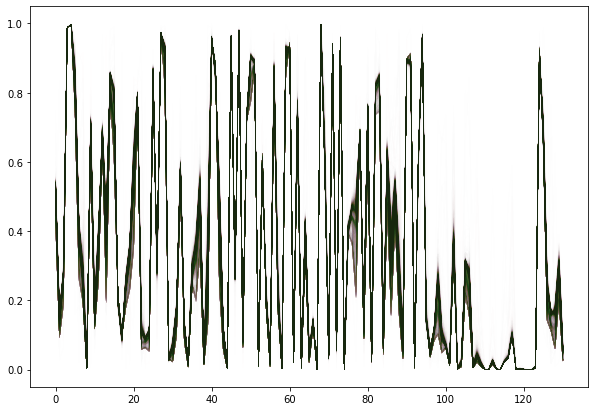

In [63]:
# looking at the distribution of all outputs we get from the RNN
# --> is there any kind of spread on these or are we just always getting the same prediction?
plt.figure(figsize=(10,7))

for trial in range(rnn_m100_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m100_out[trial, t], alpha=0.002)

plt.show()

In [64]:
m100_nospike, m100_spike = calculate_avg_pred_prob_onestep_RNN(rnn_biggerM, spikes)
print(m100_nospike)
print(m100_spike)

0.5471001267433167
0.32372501492500305


***Stage 2 training***

In [124]:
# Unfreezing the encoder
rnn_biggerM.encoder[0].weight.requires_grad = True
rnn_biggerM.encoder[0].bias.requires_grad = True
rnn_biggerM.encoder[2].weight.requires_grad = True
rnn_biggerM.encoder[2].bias.requires_grad = True
rnn_biggerM.encoder[4].weight.requires_grad = True
rnn_biggerM.encoder[4].bias.requires_grad = True
# Unfreezing the decoder
rnn_biggerM.decoder[0].weight.requires_grad = True
rnn_biggerM.decoder[0].bias.requires_grad = True
rnn_biggerM.decoder[2].weight.requires_grad = True
rnn_biggerM.decoder[2].bias.requires_grad = True
rnn_biggerM.decoder[4].weight.requires_grad = True
rnn_biggerM.decoder[4].bias.requires_grad = True

In [125]:
_ = rnn_train(rnn_biggerM, 50, seq_loader, num_epochs=5, learning_rate=0.001)

[1,    50] loss: 0.970
[1,   100] loss: 0.833
[1,   150] loss: 0.824
[1,   200] loss: 0.823
[1,   250] loss: 0.833
[1,   300] loss: 0.828
[1,   350] loss: 0.813
[1,   400] loss: 0.825
[1,   450] loss: 0.816
[2,    50] loss: 0.815
[2,   100] loss: 0.835
[2,   150] loss: 0.803
[2,   200] loss: 0.843
[2,   250] loss: 0.822
[2,   300] loss: 0.821
[2,   350] loss: 0.818
[2,   400] loss: 0.804
[2,   450] loss: 0.839
[3,    50] loss: 0.813
[3,   100] loss: 0.848
[3,   150] loss: 0.815
[3,   200] loss: 0.834
[3,   250] loss: 0.818
[3,   300] loss: 0.788
[3,   350] loss: 0.827
[3,   400] loss: 0.832
[3,   450] loss: 0.819
[4,    50] loss: 0.828
[4,   100] loss: 0.837
[4,   150] loss: 0.804
[4,   200] loss: 0.816
[4,   250] loss: 0.815
[4,   300] loss: 0.826
[4,   350] loss: 0.823
[4,   400] loss: 0.829
[4,   450] loss: 0.806
[5,    50] loss: 0.831
[5,   100] loss: 0.810
[5,   150] loss: 0.805
[5,   200] loss: 0.842
[5,   250] loss: 0.822
[5,   300] loss: 0.818
[5,   350] loss: 0.805
[5,   400] 

0.012665207497775555


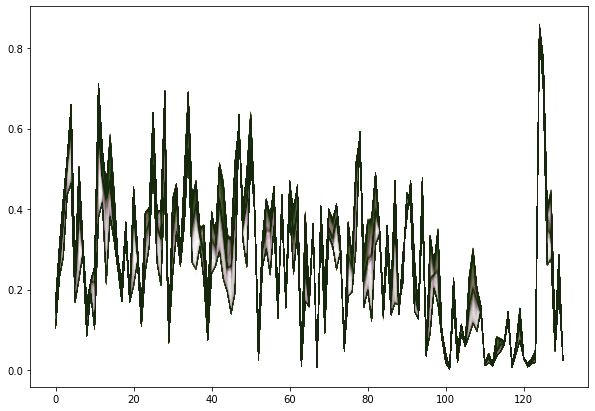

In [126]:
ans, rnn_m100_out = is_output_constant(rnn_biggerM, spikes)
print(ans)

# looking at the distribution of all outputs we get from the RNN
# --> is there any kind of spread on these or are we just always getting the same prediction?
plt.figure(figsize=(10,7))

for trial in range(rnn_m100_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m100_out[trial, t], alpha=0.002)

plt.show()

In [127]:
m100_nospike, m100_spike = calculate_avg_pred_prob_onestep_RNN(rnn_biggerM, spikes)
print(m100_nospike)
print(m100_spike)

0.31117236614227295
0.41034531593322754


# So far we've seen the strange results that for both M=10 and M=100, our trained model learns to ignore its input, and the M=100 model achieves a model performance worse than a (weighted) random guess.

# *Below we will examine the performance of models with M=20,30,... and see how the models change with different hidden dimension*

### First, we will write a method to automate the multi-stage training and initialization procedure

In [200]:
def create_and_train_rnn_model(m, dataloader):
    '''
    Function to automate the process of instantiating and training one of our
    next-step predictor RNN models. This method will return the trained model
    for further inspection.
    '''
    
    #1) We instantiate and train the Phase 1 FFW autoencoder
    dp = '../pytorch_experiments/binary_spike_matrix_data/all_trial_data_BINNED_715093703_11_30_50.npy'
    # setting the bottleneck dimension to 100 (hardly a decrease from 131 in the input)
    w = 100
    tau = 0
    epochs = 5
    print('======= BEGINNING FEED-FORWARD MODEL TRAINING =======')
    ffw_model, _ = run_experiment(data_path=dp, num_layers=3, bottleneck_dim=m, bce_weight=w, tau=tau, epochs=epochs)
    
    # 2) Instantiate the RNN model
    rnn = RNN_nextstep(131,m,num_layers=3)
#     rnn = RNN_relu(131,m,num_layers=3)
    
    # 3) Initialize the FFW weights with the phase 1 model's weights
    with torch.no_grad():
        # assigning the encoder weights
        rnn.encoder[0].weight = ffw_model.encoder[0].weight
        rnn.encoder[0].bias = ffw_model.encoder[0].bias
        rnn.encoder[2].weight = ffw_model.encoder[2].weight
        rnn.encoder[2].bias = ffw_model.encoder[2].bias
        rnn.encoder[4].weight = ffw_model.encoder[4].weight
        rnn.encoder[4].bias = ffw_model.encoder[4].bias
        # assigning the decoder weights
        rnn.decoder[0].weight = ffw_model.decoder[0].weight
        rnn.decoder[0].bias = ffw_model.decoder[0].bias
        rnn.decoder[2].weight = ffw_model.decoder[2].weight
        rnn.decoder[2].bias = ffw_model.decoder[2].bias
        rnn.decoder[4].weight = ffw_model.decoder[4].weight
        rnn.decoder[4].bias = ffw_model.decoder[4].bias
        
    # 4) Freeze the encoder and decoder layers
    # freezing the encoder
    rnn.encoder[0].weight.requires_grad = False
    rnn.encoder[0].bias.requires_grad = False
    rnn.encoder[2].weight.requires_grad = False
    rnn.encoder[2].bias.requires_grad = False
    rnn.encoder[4].weight.requires_grad = False
    rnn.encoder[4].bias.requires_grad = False
    # freezing the decoder
    rnn.decoder[0].weight.requires_grad = False
    rnn.decoder[0].bias.requires_grad = False
    rnn.decoder[2].weight.requires_grad = False
    rnn.decoder[2].bias.requires_grad = False
    rnn.decoder[4].weight.requires_grad = False
    rnn.decoder[4].bias.requires_grad = False
    
    # 5) Initialize the RNN weights
    # create empty tensors
    w1_ih = torch.empty(m,m)
    w1_hh = torch.empty(m,m)

    # initialize them with the identity
    nn.init.eye_(w1_ih)
    nn.init.eye_(w1_hh)

    # add low-magnitude random noise to avoid issues with zero-gradients
    # --> we'll get different noise additions for our other two layers
    w1_ih = w1_ih + (0.01)*torch.randn(m,m)
    w1_hh = w1_hh + (0.01)*torch.randn(m,m)
    w2_ih = w1_ih + (0.01)*torch.randn(m,m)
    w2_hh = w1_hh + (0.01)*torch.randn(m,m)
    w3_ih = w1_ih + (0.01)*torch.randn(m,m)
    w3_hh = w1_hh + (0.01)*torch.randn(m,m)


    # assign these to the weights in the RNN layer
    with torch.no_grad():
        rnn.rnn.weight_ih_l0 = nn.Parameter(w1_ih)
        rnn.rnn.weight_hh_l0 = nn.Parameter(w1_hh)
        rnn.rnn.weight_ih_l1 = nn.Parameter(w2_ih)
        rnn.rnn.weight_hh_l1 = nn.Parameter(w2_hh)
        rnn.rnn.weight_ih_l2 = nn.Parameter(w3_ih)
        rnn.rnn.weight_hh_l2 = nn.Parameter(w3_hh)
        
    # 6) Stage 1 training
    print('======== BEGINNING RNN TRAINING STAGE 1: learning rate = 0.001 =========')
    _ = rnn_train(rnn, 50, dataloader, num_epochs=2, learning_rate=0.001)
    print('======== STAGE 1 continued: learning rate = 0.0005 =========')
    _ = rnn_train(rnn, 50, dataloader, num_epochs=3, learning_rate=0.0005)
    
    # 7) Unfreeze the encoder and decoder
    # UNfreezing the encoder
    rnn.encoder[0].weight.requires_grad = True
    rnn.encoder[0].bias.requires_grad = True
    rnn.encoder[2].weight.requires_grad = True
    rnn.encoder[2].bias.requires_grad = True
    rnn.encoder[4].weight.requires_grad = True
    rnn.encoder[4].bias.requires_grad = True
    # UNfreezing the decoder
    rnn.decoder[0].weight.requires_grad = True
    rnn.decoder[0].bias.requires_grad = True
    rnn.decoder[2].weight.requires_grad = True
    rnn.decoder[2].bias.requires_grad = True
    rnn.decoder[4].weight.requires_grad = True
    rnn.decoder[4].bias.requires_grad = True
    
    # 8) Stage 2 training
    print('======== BEGINNING RNN TRAINING STAGE 2 =========')
    _ = rnn_train(rnn, 50, dataloader, num_epochs=4, learning_rate=0.001)
    
    # return the trained RNN
    return rnn

## M=20 model:

*This training was done with a learning rate of 0.001, but we'll reduce that in subsequent experiments to see if we can sacrifice convergence time for a better optimum*

In [68]:
rnn_m20 = create_and_train_rnn_model(20, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.387
[1,  2000] loss: 0.189
[1,  3000] loss: 0.136
[1,  4000] loss: 0.109
[1,  5000] loss: 0.089
[1,  6000] loss: 0.077
[1,  7000] loss: 0.068
[1,  8000] loss: 0.060
[1,  9000] loss: 0.055
[2,  1000] loss: 0.047
[2,  2000] loss: 0.045
[2,  3000] loss: 0.042
[2,  4000] loss: 0.043
[2,  5000] loss: 0.038
[2,  6000] loss: 0.039
[2,  7000] loss: 0.038
[2,  8000] loss: 0.036
[2,  9000] loss: 0.038
[3,  1000] loss: 0.032
[3,  2000] loss: 0.032
[3,  3000] loss: 0.035
[3,  4000] loss: 0.031
[3,  5000] loss: 0.032
[3,  6000] loss: 0.029
[3,  7000] loss: 0.032
[3,  8000] loss: 0.030
[3,  9000] loss: 0.031
[4,  1000] loss: 0.028
[4,  2000] loss: 0.029
[4,  3000] loss: 0.027
[4,  4000] loss: 0.028
[4,  5000] loss: 0.027
[4,  6000] loss: 0.026
[4,  7000] loss: 0.027
[4,  8000] loss: 0.026
[4,  9000] loss: 0.026
[5,  1000] loss: 0.024
[5,  2000] loss: 0.026
[5,  3000] loss: 0.025
[5,  4000] loss: 0.022
[5,  5000] loss: 0.025
[5,

***Inspecting the model:***

1) Does the model's output ignore its input?

In [69]:
rnn_m20_ans, rnn_m20_out = is_output_constant(rnn_m20, spikes)
print(rnn_m20_ans)

True


2) What do the model's outputs look like?

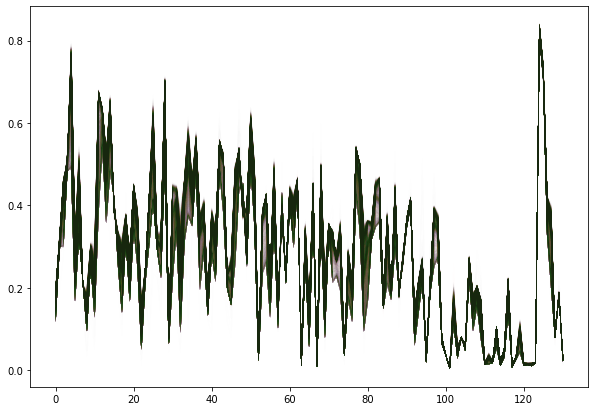

In [70]:
plt.figure(figsize=(10,7))

for trial in range(rnn_m20_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m20_out[trial, t], alpha=0.002)

plt.show()

3) What are the model's average predicted probabilities of spiking?

In [71]:
m20_nospike, m20_spike = calculate_avg_pred_prob_onestep_RNN(rnn_m20, spikes)
print(m20_nospike)
print(m20_spike)

0.3074181079864502
0.40570467710494995


## M=30

*Run with stage 1 of rnn training comprising 2 epochs with learning rate 0.001 and then 3 with learning rate 0.0005*

In [77]:
rnn_m30 = create_and_train_rnn_model(30, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.332
[1,  2000] loss: 0.156
[1,  3000] loss: 0.120
[1,  4000] loss: 0.099
[1,  5000] loss: 0.084
[1,  6000] loss: 0.073
[1,  7000] loss: 0.066
[1,  8000] loss: 0.057
[1,  9000] loss: 0.051
[2,  1000] loss: 0.043
[2,  2000] loss: 0.042
[2,  3000] loss: 0.040
[2,  4000] loss: 0.039
[2,  5000] loss: 0.035
[2,  6000] loss: 0.034
[2,  7000] loss: 0.031
[2,  8000] loss: 0.032
[2,  9000] loss: 0.030
[3,  1000] loss: 0.029
[3,  2000] loss: 0.028
[3,  3000] loss: 0.027
[3,  4000] loss: 0.026
[3,  5000] loss: 0.024
[3,  6000] loss: 0.025
[3,  7000] loss: 0.024
[3,  8000] loss: 0.026
[3,  9000] loss: 0.022
[4,  1000] loss: 0.022
[4,  2000] loss: 0.023
[4,  3000] loss: 0.023
[4,  4000] loss: 0.021
[4,  5000] loss: 0.021
[4,  6000] loss: 0.021
[4,  7000] loss: 0.021
[4,  8000] loss: 0.020
[4,  9000] loss: 0.019
[5,  1000] loss: 0.019
[5,  2000] loss: 0.020
[5,  3000] loss: 0.017
[5,  4000] loss: 0.017
[5,  5000] loss: 0.021
[5,

***Going to change `is_output_constant` to return the maximum channel variance rather than the boolean***

In [79]:
rnn_m30_max_var, rnn_m30_out = is_output_constant(rnn_m30, spikes)
print(rnn_m30_max_var)

0.011221488937735558


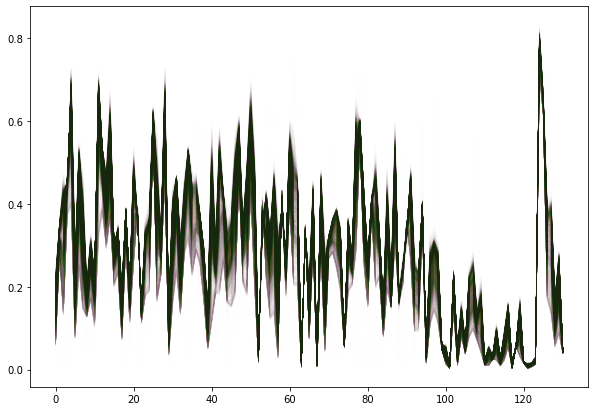

In [80]:
plt.figure(figsize=(10,7))

for trial in range(rnn_m30_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m30_out[trial, t], alpha=0.002)

plt.show()

In [81]:
m30_nospike, m30_spike = calculate_avg_pred_prob_onestep_RNN(rnn_m30, spikes)
print(m30_nospike)
print(m30_spike)

0.29754990339279175
0.3992886543273926


## M=40

*Run with stage 1 of rnn training comprising 2 epochs with learning rate 0.001 and then 5 with learning rate 0.0005*

In [82]:
rnn_m40 = create_and_train_rnn_model(40, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.343
[1,  2000] loss: 0.151
[1,  3000] loss: 0.115
[1,  4000] loss: 0.096
[1,  5000] loss: 0.083
[1,  6000] loss: 0.071
[1,  7000] loss: 0.063
[1,  8000] loss: 0.057
[1,  9000] loss: 0.050
[2,  1000] loss: 0.043
[2,  2000] loss: 0.041
[2,  3000] loss: 0.038
[2,  4000] loss: 0.038
[2,  5000] loss: 0.035
[2,  6000] loss: 0.034
[2,  7000] loss: 0.031
[2,  8000] loss: 0.032
[2,  9000] loss: 0.031
[3,  1000] loss: 0.028
[3,  2000] loss: 0.027
[3,  3000] loss: 0.026
[3,  4000] loss: 0.026
[3,  5000] loss: 0.027
[3,  6000] loss: 0.022
[3,  7000] loss: 0.024
[3,  8000] loss: 0.023
[3,  9000] loss: 0.023
[4,  1000] loss: 0.022
[4,  2000] loss: 0.021
[4,  3000] loss: 0.019
[4,  4000] loss: 0.021
[4,  5000] loss: 0.019
[4,  6000] loss: 0.019
[4,  7000] loss: 0.019
[4,  8000] loss: 0.020
[4,  9000] loss: 0.018
[5,  1000] loss: 0.015
[5,  2000] loss: 0.018
[5,  3000] loss: 0.017
[5,  4000] loss: 0.016
[5,  5000] loss: 0.017
[5,

In [83]:
rnn_m40_max_var, rnn_m40_out = is_output_constant(rnn_m40, spikes)
print(rnn_m40_max_var)

0.01829744130373001


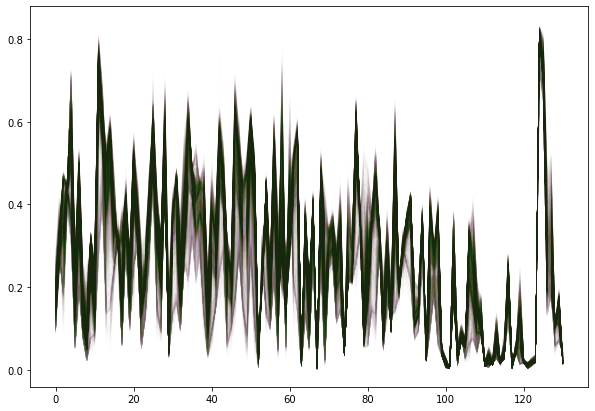

In [84]:
plt.figure(figsize=(10,7))

for trial in range(rnn_m40_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m40_out[trial, t], alpha=0.002)

plt.show()

In [85]:
m40_nospike, m40_spike = calculate_avg_pred_prob_onestep_RNN(rnn_m40, spikes)
print(m40_nospike)
print(m40_spike)

0.2907339334487915
0.3973180055618286


## M=50

In [86]:
rnn_m50 = create_and_train_rnn_model(50, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.334
[1,  2000] loss: 0.152
[1,  3000] loss: 0.110
[1,  4000] loss: 0.086
[1,  5000] loss: 0.074
[1,  6000] loss: 0.065
[1,  7000] loss: 0.059
[1,  8000] loss: 0.056
[1,  9000] loss: 0.053
[2,  1000] loss: 0.044
[2,  2000] loss: 0.045
[2,  3000] loss: 0.042
[2,  4000] loss: 0.039
[2,  5000] loss: 0.035
[2,  6000] loss: 0.037
[2,  7000] loss: 0.032
[2,  8000] loss: 0.031
[2,  9000] loss: 0.031
[3,  1000] loss: 0.028
[3,  2000] loss: 0.028
[3,  3000] loss: 0.027
[3,  4000] loss: 0.026
[3,  5000] loss: 0.023
[3,  6000] loss: 0.026
[3,  7000] loss: 0.027
[3,  8000] loss: 0.024
[3,  9000] loss: 0.022
[4,  1000] loss: 0.022
[4,  2000] loss: 0.021
[4,  3000] loss: 0.022
[4,  4000] loss: 0.021
[4,  5000] loss: 0.020
[4,  6000] loss: 0.020
[4,  7000] loss: 0.019
[4,  8000] loss: 0.019
[4,  9000] loss: 0.019
[5,  1000] loss: 0.018
[5,  2000] loss: 0.018
[5,  3000] loss: 0.018
[5,  4000] loss: 0.017
[5,  5000] loss: 0.019
[5,

In [87]:
rnn_m50_max_var, rnn_m50_out = is_output_constant(rnn_m50, spikes)
print(rnn_m50_max_var)

0.014730315655469894


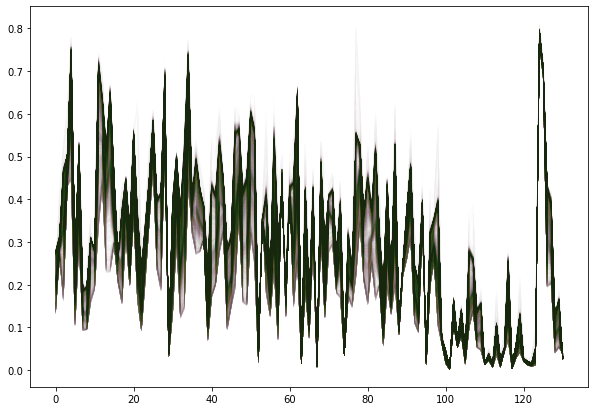

In [88]:
plt.figure(figsize=(10,7))

for trial in range(rnn_m50_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m50_out[trial, t], alpha=0.002)

plt.show()

In [89]:
m50_nospike, m50_spike = calculate_avg_pred_prob_onestep_RNN(rnn_m50, spikes)
print(m50_nospike)
print(m50_spike)

0.30794650316238403
0.4105750024318695


## M=60

In [90]:
rnn_m60 = create_and_train_rnn_model(60, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.319
[1,  2000] loss: 0.132
[1,  3000] loss: 0.100
[1,  4000] loss: 0.081
[1,  5000] loss: 0.072
[1,  6000] loss: 0.067
[1,  7000] loss: 0.060
[1,  8000] loss: 0.057
[1,  9000] loss: 0.052
[2,  1000] loss: 0.047
[2,  2000] loss: 0.044
[2,  3000] loss: 0.041
[2,  4000] loss: 0.040
[2,  5000] loss: 0.038
[2,  6000] loss: 0.036
[2,  7000] loss: 0.037
[2,  8000] loss: 0.036
[2,  9000] loss: 0.032
[3,  1000] loss: 0.031
[3,  2000] loss: 0.031
[3,  3000] loss: 0.031
[3,  4000] loss: 0.028
[3,  5000] loss: 0.026
[3,  6000] loss: 0.027
[3,  7000] loss: 0.026
[3,  8000] loss: 0.025
[3,  9000] loss: 0.025
[4,  1000] loss: 0.022
[4,  2000] loss: 0.021
[4,  3000] loss: 0.022
[4,  4000] loss: 0.021
[4,  5000] loss: 0.022
[4,  6000] loss: 0.020
[4,  7000] loss: 0.020
[4,  8000] loss: 0.020
[4,  9000] loss: 0.020
[5,  1000] loss: 0.019
[5,  2000] loss: 0.018
[5,  3000] loss: 0.018
[5,  4000] loss: 0.018
[5,  5000] loss: 0.020
[5,

In [91]:
rnn_m60_max_var, rnn_m60_out = is_output_constant(rnn_m60, spikes)
print(rnn_m60_max_var)

0.016808364540338516


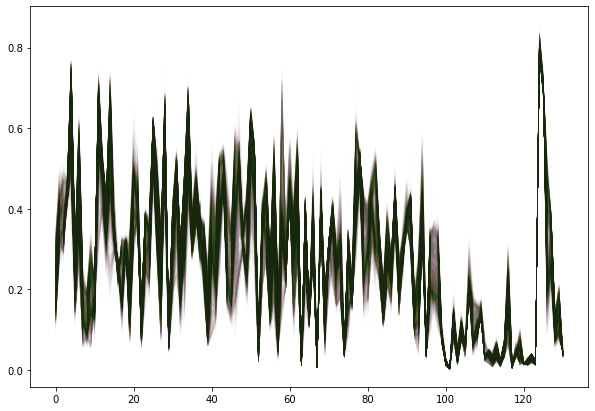

In [92]:
plt.figure(figsize=(10,7))

for trial in range(rnn_m60_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m60_out[trial, t], alpha=0.002)

plt.show()

In [93]:
m60_nospike, m60_spike = calculate_avg_pred_prob_onestep_RNN(rnn_m60, spikes)
print(m60_nospike)
print(m60_spike)

0.2891043424606323
0.39321568608283997


## M=70

In [94]:
rnn_m70 = create_and_train_rnn_model(70, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.307
[1,  2000] loss: 0.138
[1,  3000] loss: 0.107
[1,  4000] loss: 0.091
[1,  5000] loss: 0.077
[1,  6000] loss: 0.070
[1,  7000] loss: 0.063
[1,  8000] loss: 0.058
[1,  9000] loss: 0.053
[2,  1000] loss: 0.049
[2,  2000] loss: 0.047
[2,  3000] loss: 0.044
[2,  4000] loss: 0.042
[2,  5000] loss: 0.041
[2,  6000] loss: 0.040
[2,  7000] loss: 0.039
[2,  8000] loss: 0.038
[2,  9000] loss: 0.035
[3,  1000] loss: 0.034
[3,  2000] loss: 0.033
[3,  3000] loss: 0.033
[3,  4000] loss: 0.033
[3,  5000] loss: 0.030
[3,  6000] loss: 0.029
[3,  7000] loss: 0.027
[3,  8000] loss: 0.026
[3,  9000] loss: 0.027
[4,  1000] loss: 0.027
[4,  2000] loss: 0.025
[4,  3000] loss: 0.024
[4,  4000] loss: 0.022
[4,  5000] loss: 0.024
[4,  6000] loss: 0.022
[4,  7000] loss: 0.022
[4,  8000] loss: 0.025
[4,  9000] loss: 0.023
[5,  1000] loss: 0.021
[5,  2000] loss: 0.019
[5,  3000] loss: 0.022
[5,  4000] loss: 0.021
[5,  5000] loss: 0.021
[5,

In [95]:
rnn_m70_max_var, rnn_m70_out = is_output_constant(rnn_m70, spikes)
print(rnn_m70_max_var)

0.022974537685513496


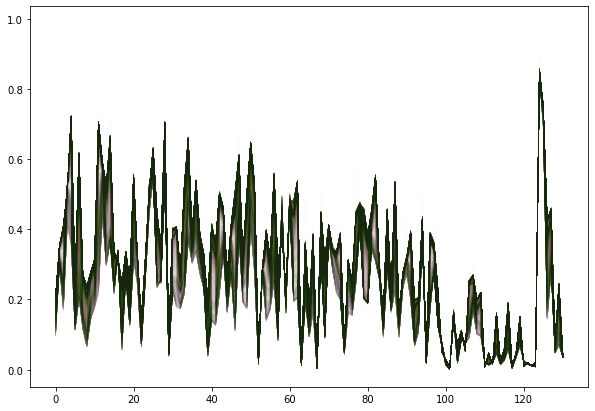

In [96]:
plt.figure(figsize=(10,7))

for trial in range(rnn_m70_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m70_out[trial, t], alpha=0.002)

plt.show()

In [97]:
m70_nospike, m70_spike = calculate_avg_pred_prob_onestep_RNN(rnn_m70, spikes)
print(m70_nospike)
print(m70_spike)

0.3096579313278198
0.41129326820373535


## M=80

In [98]:
rnn_m80 = create_and_train_rnn_model(80, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.312
[1,  2000] loss: 0.138
[1,  3000] loss: 0.110
[1,  4000] loss: 0.096
[1,  5000] loss: 0.080
[1,  6000] loss: 0.071
[1,  7000] loss: 0.067
[1,  8000] loss: 0.063
[1,  9000] loss: 0.059
[2,  1000] loss: 0.054
[2,  2000] loss: 0.052
[2,  3000] loss: 0.050
[2,  4000] loss: 0.048
[2,  5000] loss: 0.049
[2,  6000] loss: 0.047
[2,  7000] loss: 0.044
[2,  8000] loss: 0.043
[2,  9000] loss: 0.043
[3,  1000] loss: 0.041
[3,  2000] loss: 0.039
[3,  3000] loss: 0.040
[3,  4000] loss: 0.038
[3,  5000] loss: 0.036
[3,  6000] loss: 0.034
[3,  7000] loss: 0.034
[3,  8000] loss: 0.032
[3,  9000] loss: 0.032
[4,  1000] loss: 0.029
[4,  2000] loss: 0.031
[4,  3000] loss: 0.028
[4,  4000] loss: 0.028
[4,  5000] loss: 0.028
[4,  6000] loss: 0.030
[4,  7000] loss: 0.027
[4,  8000] loss: 0.026
[4,  9000] loss: 0.025
[5,  1000] loss: 0.022
[5,  2000] loss: 0.023
[5,  3000] loss: 0.024
[5,  4000] loss: 0.025
[5,  5000] loss: 0.023
[5,

In [99]:
rnn_m80_max_var, rnn_m80_out = is_output_constant(rnn_m80, spikes)
print(rnn_m80_max_var)

0.008571881800889969


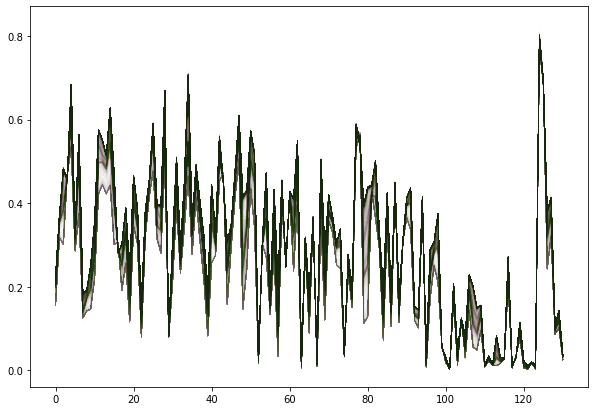

In [100]:
plt.figure(figsize=(10,7))

for trial in range(rnn_m80_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m80_out[trial, t], alpha=0.002)

plt.show()

In [101]:
m80_nospike, m80_spike = calculate_avg_pred_prob_onestep_RNN(rnn_m80, spikes)
print(m80_nospike)
print(m80_spike)

0.3248094916343689
0.4227888584136963


## M=90

In [102]:
rnn_m90 = create_and_train_rnn_model(90, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.311
[1,  2000] loss: 0.137
[1,  3000] loss: 0.106
[1,  4000] loss: 0.091
[1,  5000] loss: 0.079
[1,  6000] loss: 0.071
[1,  7000] loss: 0.068
[1,  8000] loss: 0.064
[1,  9000] loss: 0.061
[2,  1000] loss: 0.056
[2,  2000] loss: 0.052
[2,  3000] loss: 0.054
[2,  4000] loss: 0.050
[2,  5000] loss: 0.049
[2,  6000] loss: 0.046
[2,  7000] loss: 0.046
[2,  8000] loss: 0.042
[2,  9000] loss: 0.043
[3,  1000] loss: 0.039
[3,  2000] loss: 0.038
[3,  3000] loss: 0.038
[3,  4000] loss: 0.040
[3,  5000] loss: 0.036
[3,  6000] loss: 0.035
[3,  7000] loss: 0.034
[3,  8000] loss: 0.034
[3,  9000] loss: 0.031
[4,  1000] loss: 0.033
[4,  2000] loss: 0.033
[4,  3000] loss: 0.030
[4,  4000] loss: 0.031
[4,  5000] loss: 0.032
[4,  6000] loss: 0.033
[4,  7000] loss: 0.030
[4,  8000] loss: 0.028
[4,  9000] loss: 0.028
[5,  1000] loss: 0.028
[5,  2000] loss: 0.028
[5,  3000] loss: 0.027
[5,  4000] loss: 0.027
[5,  5000] loss: 0.030
[5,

In [103]:
rnn_m90_max_var, rnn_m90_out = is_output_constant(rnn_m90, spikes)
print(rnn_m90_max_var)

2.43679041886935e-05


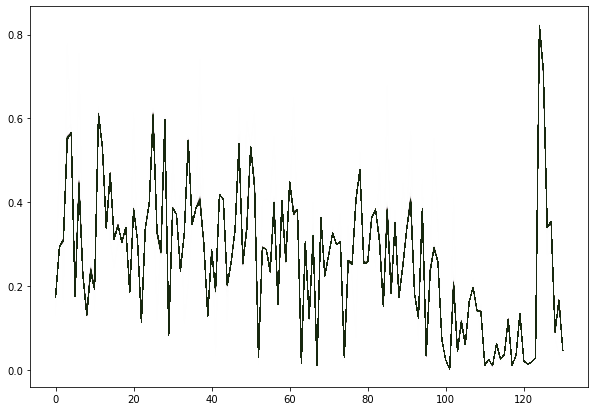

In [104]:
plt.figure(figsize=(10,7))

for trial in range(rnn_m90_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m90_out[trial, t], alpha=0.002)

plt.show()

In [105]:
m90_nospike, m90_spike = calculate_avg_pred_prob_onestep_RNN(rnn_m90, spikes)
print(m90_nospike)
print(m90_spike)

0.2851095199584961
0.37183862924575806


## M=100

In [106]:
rnn_m100 = create_and_train_rnn_model(100, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.296
[1,  2000] loss: 0.128
[1,  3000] loss: 0.101
[1,  4000] loss: 0.085
[1,  5000] loss: 0.080
[1,  6000] loss: 0.071
[1,  7000] loss: 0.068
[1,  8000] loss: 0.069
[1,  9000] loss: 0.067
[2,  1000] loss: 0.060
[2,  2000] loss: 0.061
[2,  3000] loss: 0.057
[2,  4000] loss: 0.055
[2,  5000] loss: 0.053
[2,  6000] loss: 0.053
[2,  7000] loss: 0.052
[2,  8000] loss: 0.051
[2,  9000] loss: 0.050
[3,  1000] loss: 0.046
[3,  2000] loss: 0.046
[3,  3000] loss: 0.044
[3,  4000] loss: 0.043
[3,  5000] loss: 0.043
[3,  6000] loss: 0.044
[3,  7000] loss: 0.042
[3,  8000] loss: 0.040
[3,  9000] loss: 0.038
[4,  1000] loss: 0.038
[4,  2000] loss: 0.039
[4,  3000] loss: 0.036
[4,  4000] loss: 0.034
[4,  5000] loss: 0.034
[4,  6000] loss: 0.035
[4,  7000] loss: 0.034
[4,  8000] loss: 0.034
[4,  9000] loss: 0.031
[5,  1000] loss: 0.033
[5,  2000] loss: 0.031
[5,  3000] loss: 0.031
[5,  4000] loss: 0.030
[5,  5000] loss: 0.032
[5,

In [107]:
rnn_m100_max_var, rnn_m100_out = is_output_constant(rnn_m100, spikes)
print(rnn_m100_max_var)

1.1943458957830444e-05


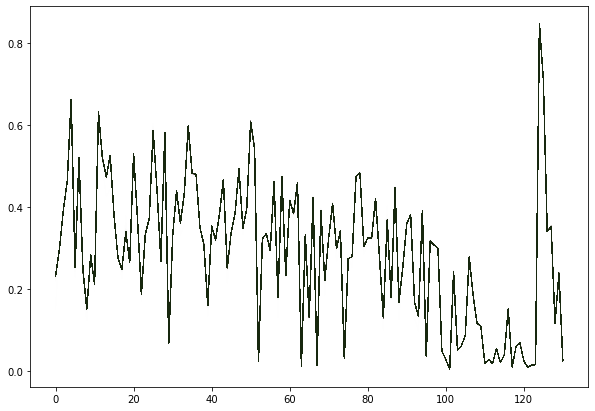

In [108]:
plt.figure(figsize=(10,7))

for trial in range(rnn_m100_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m100_out[trial, t], alpha=0.002)

plt.show()

In [109]:
m100_nospike, m100_spike = calculate_avg_pred_prob_onestep_RNN(rnn_m100, spikes)
print(m100_nospike)
print(m100_spike)

0.31360602378845215
0.4043673574924469


## M=110

In [110]:
rnn_m110 = create_and_train_rnn_model(110, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.291
[1,  2000] loss: 0.124
[1,  3000] loss: 0.101
[1,  4000] loss: 0.091
[1,  5000] loss: 0.086
[1,  6000] loss: 0.079
[1,  7000] loss: 0.076
[1,  8000] loss: 0.074
[1,  9000] loss: 0.071
[2,  1000] loss: 0.066
[2,  2000] loss: 0.065
[2,  3000] loss: 0.061
[2,  4000] loss: 0.062
[2,  5000] loss: 0.058
[2,  6000] loss: 0.059
[2,  7000] loss: 0.056
[2,  8000] loss: 0.055
[2,  9000] loss: 0.055
[3,  1000] loss: 0.050
[3,  2000] loss: 0.049
[3,  3000] loss: 0.050
[3,  4000] loss: 0.050
[3,  5000] loss: 0.049
[3,  6000] loss: 0.048
[3,  7000] loss: 0.048
[3,  8000] loss: 0.044
[3,  9000] loss: 0.045
[4,  1000] loss: 0.043
[4,  2000] loss: 0.044
[4,  3000] loss: 0.043
[4,  4000] loss: 0.043
[4,  5000] loss: 0.042
[4,  6000] loss: 0.041
[4,  7000] loss: 0.040
[4,  8000] loss: 0.041
[4,  9000] loss: 0.041
[5,  1000] loss: 0.040
[5,  2000] loss: 0.041
[5,  3000] loss: 0.040
[5,  4000] loss: 0.036
[5,  5000] loss: 0.038
[5,

In [111]:
rnn_m110_max_var, rnn_m110_out = is_output_constant(rnn_m110, spikes)
print(rnn_m110_max_var)

0.0014751639682799578


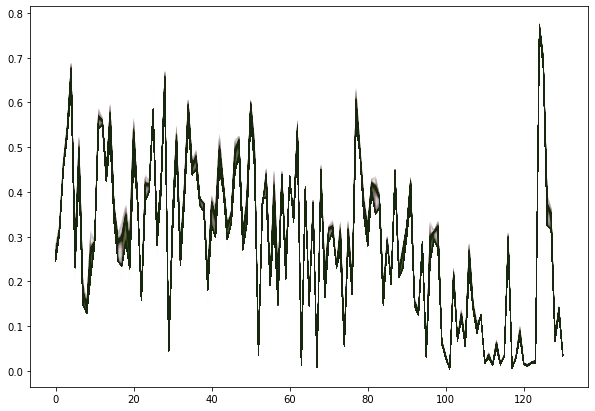

In [112]:
plt.figure(figsize=(10,7))

for trial in range(rnn_m110_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m110_out[trial, t], alpha=0.002)

plt.show()

In [113]:
m110_nospike, m110_spike = calculate_avg_pred_prob_onestep_RNN(rnn_m110, spikes)
print(m110_nospike)
print(m110_spike)

0.3093292713165283
0.4026908576488495


## M=120

In [114]:
rnn_m120 = create_and_train_rnn_model(120, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.279
[1,  2000] loss: 0.126
[1,  3000] loss: 0.104
[1,  4000] loss: 0.094
[1,  5000] loss: 0.087
[1,  6000] loss: 0.084
[1,  7000] loss: 0.080
[1,  8000] loss: 0.079
[1,  9000] loss: 0.077
[2,  1000] loss: 0.068
[2,  2000] loss: 0.068
[2,  3000] loss: 0.067
[2,  4000] loss: 0.064
[2,  5000] loss: 0.066
[2,  6000] loss: 0.061
[2,  7000] loss: 0.062
[2,  8000] loss: 0.058
[2,  9000] loss: 0.056
[3,  1000] loss: 0.055
[3,  2000] loss: 0.056
[3,  3000] loss: 0.053
[3,  4000] loss: 0.053
[3,  5000] loss: 0.051
[3,  6000] loss: 0.051
[3,  7000] loss: 0.052
[3,  8000] loss: 0.049
[3,  9000] loss: 0.047
[4,  1000] loss: 0.047
[4,  2000] loss: 0.044
[4,  3000] loss: 0.045
[4,  4000] loss: 0.046
[4,  5000] loss: 0.043
[4,  6000] loss: 0.042
[4,  7000] loss: 0.043
[4,  8000] loss: 0.044
[4,  9000] loss: 0.044
[5,  1000] loss: 0.040
[5,  2000] loss: 0.041
[5,  3000] loss: 0.040
[5,  4000] loss: 0.037
[5,  5000] loss: 0.038
[5,

In [115]:
rnn_m120_max_var, rnn_m120_out = is_output_constant(rnn_m120, spikes)
print(rnn_m120_max_var)

0.009516199119389057


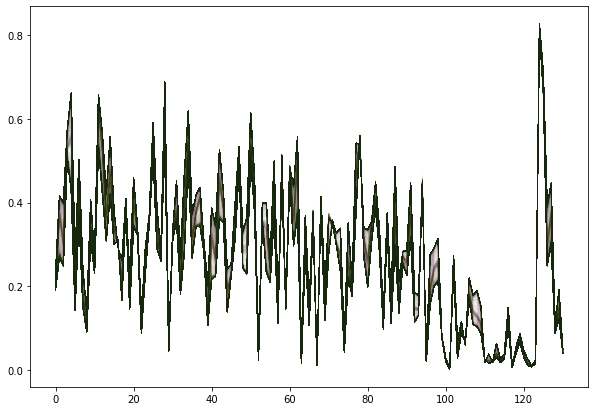

In [116]:
plt.figure(figsize=(10,7))

for trial in range(rnn_m120_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m120_out[trial, t], alpha=0.002)

plt.show()

In [117]:
m120_nospike, m120_spike = calculate_avg_pred_prob_onestep_RNN(rnn_m120, spikes)
print(m120_nospike)
print(m120_spike)

0.3018074631690979
0.3996439278125763


## M=130

In [118]:
rnn_m130 = create_and_train_rnn_model(130, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.287
[1,  2000] loss: 0.120
[1,  3000] loss: 0.092
[1,  4000] loss: 0.080
[1,  5000] loss: 0.076
[1,  6000] loss: 0.075
[1,  7000] loss: 0.075
[1,  8000] loss: 0.069
[1,  9000] loss: 0.069
[2,  1000] loss: 0.064
[2,  2000] loss: 0.065
[2,  3000] loss: 0.065
[2,  4000] loss: 0.062
[2,  5000] loss: 0.065
[2,  6000] loss: 0.061
[2,  7000] loss: 0.060
[2,  8000] loss: 0.061
[2,  9000] loss: 0.059
[3,  1000] loss: 0.057
[3,  2000] loss: 0.058
[3,  3000] loss: 0.056
[3,  4000] loss: 0.054
[3,  5000] loss: 0.053
[3,  6000] loss: 0.054
[3,  7000] loss: 0.053
[3,  8000] loss: 0.051
[3,  9000] loss: 0.049
[4,  1000] loss: 0.046
[4,  2000] loss: 0.049
[4,  3000] loss: 0.046
[4,  4000] loss: 0.045
[4,  5000] loss: 0.045
[4,  6000] loss: 0.047
[4,  7000] loss: 0.046
[4,  8000] loss: 0.045
[4,  9000] loss: 0.043
[5,  1000] loss: 0.042
[5,  2000] loss: 0.045
[5,  3000] loss: 0.047
[5,  4000] loss: 0.044
[5,  5000] loss: 0.042
[5,

In [119]:
rnn_m130_max_var, rnn_m130_out = is_output_constant(rnn_m130, spikes)
print(rnn_m130_max_var)

7.691171958867926e-06


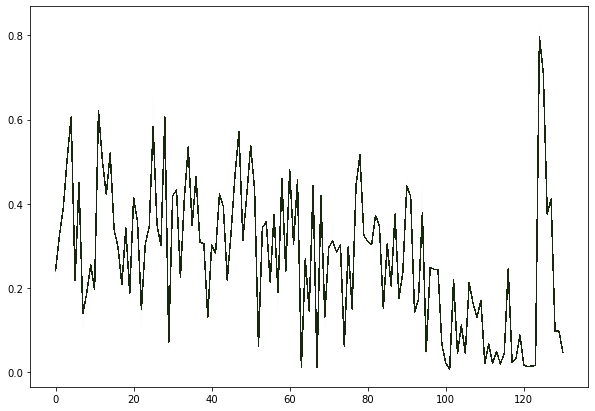

In [120]:
plt.figure(figsize=(10,7))

for trial in range(rnn_m130_out.shape[0]):
    for t in random.sample(range(2000), 10):
        plt.plot(rnn_m130_out[trial, t], alpha=0.002)

plt.show()

In [121]:
m130_nospike, m130_spike = calculate_avg_pred_prob_onestep_RNN(rnn_m130, spikes)
print(m130_nospike)
print(m130_spike)

0.29674071073532104
0.38545137643814087


# Running experiments on dynamical synthetic data

The resuls above lead us to think that since our RNN model could not learn the one-step update rule present in the empirical data, that update rule (and more broadly, the dynamics in general) is too complex to be expressed by our model. To test that hypothesis we will check whether our model can learn the dynamics present in a more simple dataset. To construct one such dataset we have generated the following data with known cyclic dynamics. Below we will run the same experiments and see if our model gives degenerate output (ignoring the input) when faced with the task of learning the next-step update rule present in our synthetic data.

*Rerunning the M=131 & one-stage training but with synthetic data that has sorted firing rate functions (i.e. channel i peaks just before channel i+1, etc.)*

In [275]:
with open('../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_SORTED_spike_mtx__16_48_50.npy', 'rb') as f:
    sorted_spikes = np.load(f, allow_pickle=True)

In [276]:
sorted_spikes.shape

(487, 131, 2001)

***The sorted synthetic data should show the cascading probability functions across all channels versus time:***

Getting the channel,time coordinates of all the spikes in the first trial

In [402]:
ones = list(zip(*list(np.argwhere(sorted_spikes[0]))))

In [403]:
max(ones[0])

130

***Plotting the spikes per channel versus time for the first trial – this confirms the banded structure of the units in this set of synthetic data***

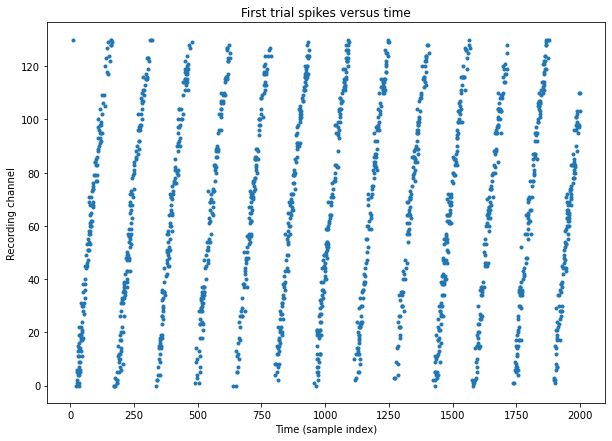

In [449]:
plt.figure(figsize=(10,7))
plt.scatter(x = ones[1], y = ones[0], marker='.')
plt.xlabel('Time (sample index)')
plt.ylabel('Recording channel')
plt.title('First trial spikes versus time')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/dyn_data_spikes_sigma5.png', dpi=300)
plt.show()

## Training the full M=131 model (one-stage training) on this sorted data (equivalent to giving it unsorted data), and letting it train for many epochs

In [294]:
sorted_synthetic_dataset = SequenceDataset(torch.from_numpy(sorted_spikes).float())

sorted_synthetic_loader = DataLoader(sorted_synthetic_dataset, batch_size=1, shuffle=True)

In [297]:
sorted_rnn_m131_randinit = RNN_nextstep(131,131,num_layers=3)

_ = rnn_train(sorted_rnn_m131_randinit, 50, sorted_synthetic_loader, num_epochs=10, learning_rate=0.001)

[1,    50] loss: 0.753
[1,   100] loss: 0.733
[1,   150] loss: 0.732
[1,   200] loss: 0.730
[1,   250] loss: 0.732
[1,   300] loss: 0.733
[1,   350] loss: 0.731
[1,   400] loss: 0.733
[1,   450] loss: 0.732
[2,    50] loss: 0.732
[2,   100] loss: 0.732
[2,   150] loss: 0.733
[2,   200] loss: 0.717
[2,   250] loss: 0.616
[2,   300] loss: 0.598
[2,   350] loss: 0.571
[2,   400] loss: 0.541
[2,   450] loss: 0.606
[3,    50] loss: 0.523
[3,   100] loss: 0.473
[3,   150] loss: 0.456
[3,   200] loss: 0.453
[3,   250] loss: 0.487
[3,   300] loss: 0.609
[3,   350] loss: 0.464
[3,   400] loss: 0.436
[3,   450] loss: 0.409
[4,    50] loss: 0.340
[4,   100] loss: 0.328
[4,   150] loss: 0.321
[4,   200] loss: 0.313
[4,   250] loss: 0.307
[4,   300] loss: 0.305
[4,   350] loss: 0.304
[4,   400] loss: 0.302
[4,   450] loss: 0.299
[5,    50] loss: 0.297
[5,   100] loss: 0.296
[5,   150] loss: 0.297
[5,   200] loss: 0.296
[5,   250] loss: 0.295
[5,   300] loss: 0.295
[5,   350] loss: 0.295
[5,   400] 

In [298]:
_ = rnn_train(sorted_rnn_m131_randinit, 50, sorted_synthetic_loader, num_epochs=5, learning_rate=0.0005)

[1,    50] loss: 0.297
[1,   100] loss: 0.286
[1,   150] loss: 0.286
[1,   200] loss: 0.287
[1,   250] loss: 0.286
[1,   300] loss: 0.287
[1,   350] loss: 0.286
[1,   400] loss: 0.286
[1,   450] loss: 0.286
[2,    50] loss: 0.286
[2,   100] loss: 0.287
[2,   150] loss: 0.286
[2,   200] loss: 0.287
[2,   250] loss: 0.287
[2,   300] loss: 0.287
[2,   350] loss: 0.285
[2,   400] loss: 0.287
[2,   450] loss: 0.285
[3,    50] loss: 0.286
[3,   100] loss: 0.285
[3,   150] loss: 0.286
[3,   200] loss: 0.285
[3,   250] loss: 0.286
[3,   300] loss: 0.285
[3,   350] loss: 0.286
[3,   400] loss: 0.285
[3,   450] loss: 0.286
[4,    50] loss: 0.285
[4,   100] loss: 0.285
[4,   150] loss: 0.286
[4,   200] loss: 0.287
[4,   250] loss: 0.286
[4,   300] loss: 0.285
[4,   350] loss: 0.285
[4,   400] loss: 0.285
[4,   450] loss: 0.285
[5,    50] loss: 0.284
[5,   100] loss: 0.286
[5,   150] loss: 0.286
[5,   200] loss: 0.284
[5,   250] loss: 0.284
[5,   300] loss: 0.285
[5,   350] loss: 0.285
[5,   400] 

In [299]:
sorted_rnn_m131_max_var, sorted_rnn_m131_out = is_output_constant(sorted_rnn_m131_randinit, sorted_spikes)
print(sorted_rnn_m131_max_var)

0.062334321439266205


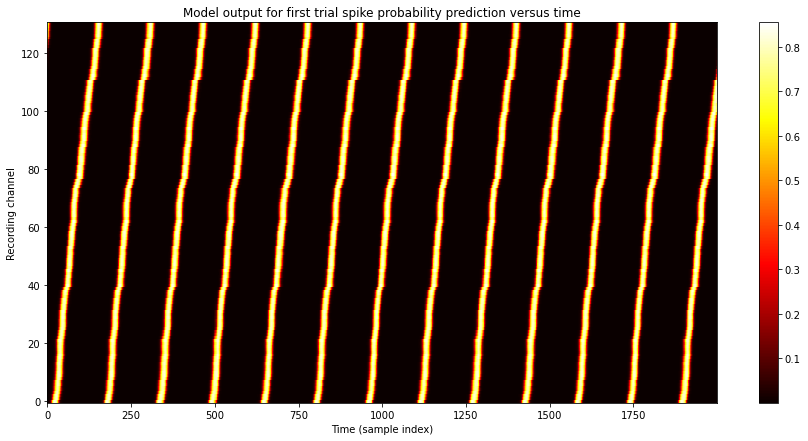

In [454]:
plt.figure(figsize=(15,7))
plt.imshow(sorted_rnn_m131_out[0].T, cmap='hot', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('Time (sample index)')
plt.ylabel('Recording channel')
plt.title('Model output for first trial spike probability prediction versus time')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/dynam_rnn_m131_heatmap.png', dpi=300)
plt.show()

In [306]:
sorted_m131_nospike, sorted_m131_spike = calculate_avg_pred_prob_onestep_RNN(sorted_rnn_m131_randinit, sorted_spikes)
print(sorted_m131_nospike)
print(sorted_m131_spike)

0.14857983589172363
0.6796163320541382


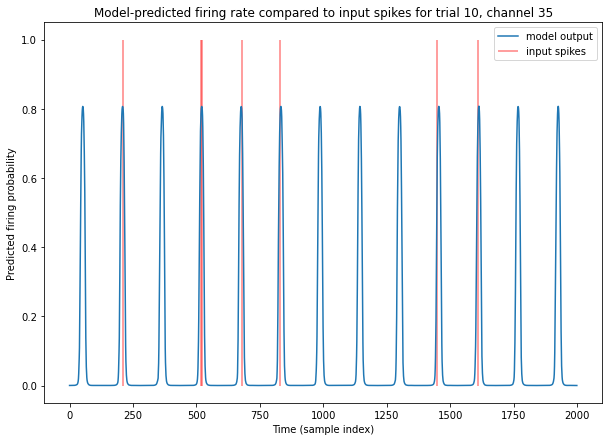

In [453]:
trial = 10
channel = 35

plt.figure(figsize=(10,7))
plt.plot(sorted_rnn_m131_out[trial, :, channel], label='model output')
plt.vlines(x=np.argwhere(sorted_spikes[trial,channel,:]), ymin=0.0, ymax=1.0, colors='r', alpha=0.5, label='input spikes')
plt.xlabel('Time (sample index)')
plt.ylabel('Predicted firing probability')
plt.title(f'Model-predicted firing rate compared to input spikes for trial {trial}, channel {channel}')
plt.legend()
plt.show()

***Saving the trained model for safety***

In [312]:
# torch.save(sorted_rnn_m131_randinit, 'sorted_input_rnn_m131.pt')

/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RNN_nextstep. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon l

## For comparison we will run an identical experiment with the empirical data

### ... and to have a matching spike plot from the empirical data:

In [480]:
empirical_one_coords = list(zip(*list(np.argwhere(spikes[0]))))

In [481]:
max(empirical_one_coords[0])

129

***Plotting the spikes per channel versus time for the first trial***

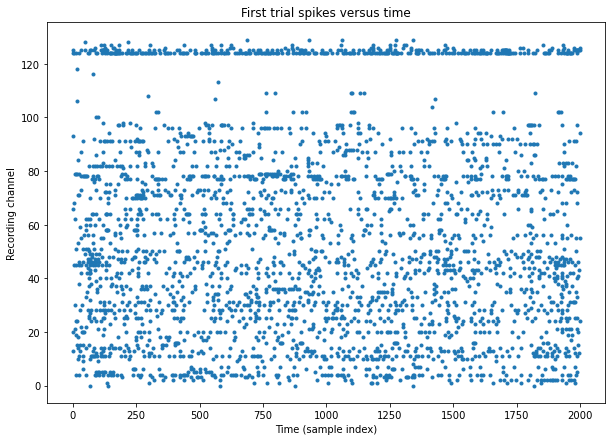

In [482]:
plt.figure(figsize=(10,7))
plt.scatter(x =empirical_one_coords[1], y =empirical_one_coords[0], marker='.')
plt.xlabel('Time (sample index)')
plt.ylabel('Recording channel')
plt.title('First trial spikes versus time')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/empirical_data_spikes.png', dpi=300)
plt.show()

In [313]:
empirical_rnn_m131_randinit = RNN_nextstep(131,131,num_layers=3)

_ = rnn_train(empirical_rnn_m131_randinit, 50, seq_loader, num_epochs=10, learning_rate=0.001)

[1,    50] loss: 0.862
[1,   100] loss: 0.819
[1,   150] loss: 0.804
[1,   200] loss: 0.837
[1,   250] loss: 0.817
[1,   300] loss: 0.807
[1,   350] loss: 0.838
[1,   400] loss: 0.825
[1,   450] loss: 0.809
[2,    50] loss: 0.828
[2,   100] loss: 0.803
[2,   150] loss: 0.818
[2,   200] loss: 0.830
[2,   250] loss: 0.830
[2,   300] loss: 0.813
[2,   350] loss: 0.818
[2,   400] loss: 0.815
[2,   450] loss: 0.830
[3,    50] loss: 0.841
[3,   100] loss: 0.817
[3,   150] loss: 0.828
[3,   200] loss: 0.806
[3,   250] loss: 0.833
[3,   300] loss: 0.802
[3,   350] loss: 0.822
[3,   400] loss: 0.798
[3,   450] loss: 0.817
[4,    50] loss: 0.824
[4,   100] loss: 0.830
[4,   150] loss: 0.814
[4,   200] loss: 0.807
[4,   250] loss: 0.822
[4,   300] loss: 0.815
[4,   350] loss: 0.811
[4,   400] loss: 0.838
[4,   450] loss: 0.805
[5,    50] loss: 0.810
[5,   100] loss: 0.812
[5,   150] loss: 0.848
[5,   200] loss: 0.798
[5,   250] loss: 0.822
[5,   300] loss: 0.814
[5,   350] loss: 0.835
[5,   400] 

In [314]:
_ = rnn_train(empirical_rnn_m131_randinit, 50, seq_loader, num_epochs=5, learning_rate=0.0005)

[1,    50] loss: 0.827
[1,   100] loss: 0.833
[1,   150] loss: 0.814
[1,   200] loss: 0.812
[1,   250] loss: 0.796
[1,   300] loss: 0.821
[1,   350] loss: 0.803
[1,   400] loss: 0.809
[1,   450] loss: 0.809
[2,    50] loss: 0.804
[2,   100] loss: 0.818
[2,   150] loss: 0.820
[2,   200] loss: 0.807
[2,   250] loss: 0.811
[2,   300] loss: 0.828
[2,   350] loss: 0.831
[2,   400] loss: 0.805
[2,   450] loss: 0.797
[3,    50] loss: 0.804
[3,   100] loss: 0.820
[3,   150] loss: 0.805
[3,   200] loss: 0.842
[3,   250] loss: 0.821
[3,   300] loss: 0.800
[3,   350] loss: 0.797
[3,   400] loss: 0.812
[3,   450] loss: 0.818
[4,    50] loss: 0.836
[4,   100] loss: 0.808
[4,   150] loss: 0.811
[4,   200] loss: 0.804
[4,   250] loss: 0.809
[4,   300] loss: 0.826
[4,   350] loss: 0.814
[4,   400] loss: 0.789
[4,   450] loss: 0.816
[5,    50] loss: 0.819
[5,   100] loss: 0.820
[5,   150] loss: 0.803
[5,   200] loss: 0.807
[5,   250] loss: 0.805
[5,   300] loss: 0.828
[5,   350] loss: 0.831
[5,   400] 

In [315]:
empirical_rnn_m131_max_var, empirical_rnn_m131_out = is_output_constant(empirical_rnn_m131_randinit, spikes)
print(empirical_rnn_m131_max_var)

0.022284982725977898


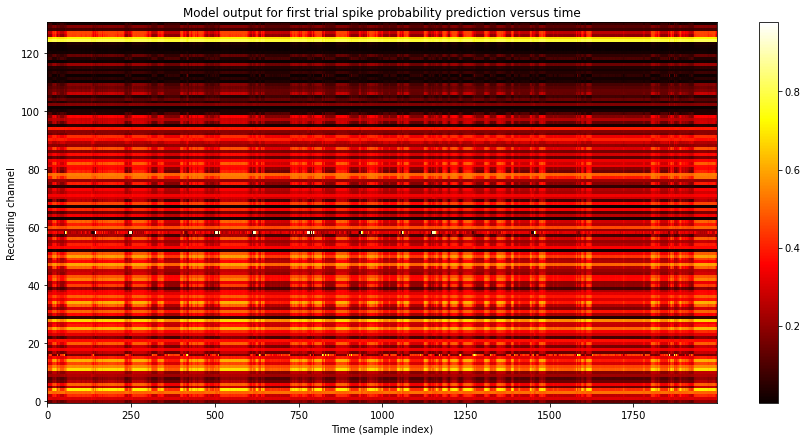

In [477]:
plt.figure(figsize=(15,7))
plt.imshow(empirical_rnn_m131_out[0].T, cmap='hot', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('Time (sample index)')
plt.ylabel('Recording channel')
plt.title('Model output for first trial spike probability prediction versus time')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/empirical_rnn_m131_heatmap.png', dpi=300)
plt.show()

In [319]:
empirical_m131_nospike, empirical_m131_spike = calculate_avg_pred_prob_onestep_RNN(empirical_rnn_m131_randinit, spikes)
print(empirical_m131_nospike)
print(empirical_m131_spike)

0.28493553400039673
0.3745763897895813


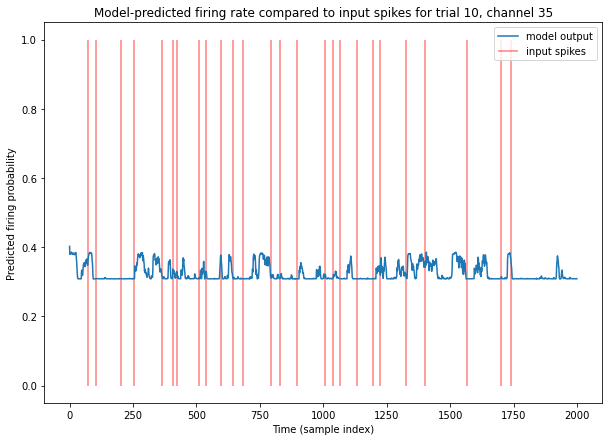

In [479]:
trial = 10
channel = 35

plt.figure(figsize=(10,7))
plt.plot(empirical_rnn_m131_out[trial, :, channel], label='model output')
plt.vlines(x=np.argwhere(spikes[trial,channel,:]), ymin=0.0, ymax=1.0, colors='r', alpha=0.5, label='input spikes')
plt.xlabel('Time (sample index)')
plt.ylabel('Predicted firing probability')
plt.title(f'Model-predicted firing rate compared to input spikes for trial {trial}, channel {channel}')
plt.legend()
plt.savefig('../../Summer/Data 2050/Practicum report/figures/empirical_rnn_m131_example_channel.png', dpi=300)
plt.show()

***Saving this model:***

In [351]:
# torch.save(empirical_rnn_m131_randinit, 'empirical_input_rnn_m131.pt')

/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RNN_nextstep. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon l

## *Here we've reached a positive result:*

In the above pair of experiments we see the model succeed to learn the dynamics in the first case. The data presented in that experiment has the very simple dynamical structure shown in the plot where we see the different channel spikes versus time from the first trial. After feeding this data through the model we see in the heatmap of the model output that the model clearly learns that same structure, and we see that supported in the individual time series plots that show in dividual output channels reflect the periodicity that was present in the input data.

The second experiment shows that under identical experimental circumstances (i.e. archietcture and initialization and training procedures) the model fails to learn time-varying dynamics. This is most clearly shown in the trial 1 heatmap that clearly shows a time-invariant output that predicts an output joint probability equal to some non-uniform prior learned in training.

## Finally, we will search for the additional negative result achieved by applying this experiment to another synthetic dataset, but this time one that is a model of the empirical data with any possible inter-channel dynamics erased

To get further context for our negative result on the empirical spike data, we create a simulated version of our spike data in which each channel contains the same number of spikes as in the empirical data, but their times are reassigned from the uniform distribution. This simulates independent Poisson processes in each channel and thus eliminates any possible inter-channel dynamics in the data.

In [321]:
with open('../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_NONDYN_spike_mtx__11_32_10.npy', 'rb') as f:
    indep_spikes = np.load(f, allow_pickle=True)

In [469]:
indep_one_coords = list(zip(*list(np.argwhere(indep_spikes[0]))))

In [470]:
max(indep_one_coords[0])

129

***Plotting the spikes per channel versus time for the first trial***

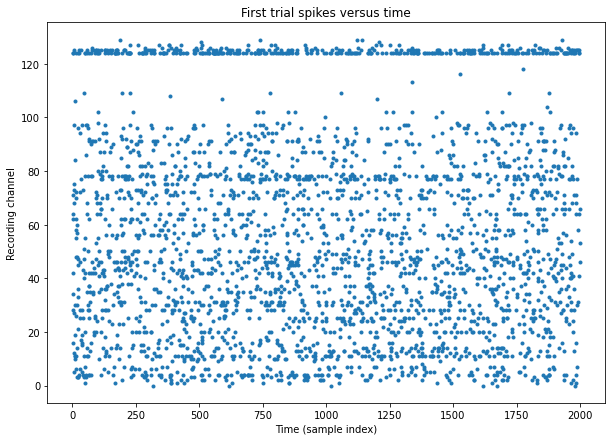

In [471]:
plt.figure(figsize=(10,7))
plt.scatter(x = indep_one_coords[1], y = indep_one_coords[0], marker='.')
plt.xlabel('Time (sample index)')
plt.ylabel('Recording channel')
plt.title('First trial spikes versus time')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/nondyn_data_spikes.png', dpi=300)
plt.show()

In [322]:
indep_dataset = SequenceDataset(torch.from_numpy(indep_spikes).float())

indep_loader = DataLoader(indep_dataset, batch_size=1, shuffle=True)

In [323]:
nondynamic_rnn_m131_randinit = RNN_nextstep(131,131,num_layers=3)

_ = rnn_train(nondynamic_rnn_m131_randinit, 50, indep_loader, num_epochs=10, learning_rate=0.001)

[1,    50] loss: 0.858
[1,   100] loss: 0.830
[1,   150] loss: 0.807
[1,   200] loss: 0.814
[1,   250] loss: 0.829
[1,   300] loss: 0.800
[1,   350] loss: 0.838
[1,   400] loss: 0.827
[1,   450] loss: 0.833
[2,    50] loss: 0.851
[2,   100] loss: 0.800
[2,   150] loss: 0.806
[2,   200] loss: 0.809
[2,   250] loss: 0.819
[2,   300] loss: 0.828
[2,   350] loss: 0.832
[2,   400] loss: 0.813
[2,   450] loss: 0.836
[3,    50] loss: 0.838
[3,   100] loss: 0.807
[3,   150] loss: 0.828
[3,   200] loss: 0.833
[3,   250] loss: 0.823
[3,   300] loss: 0.820
[3,   350] loss: 0.818
[3,   400] loss: 0.830
[3,   450] loss: 0.794
[4,    50] loss: 0.834
[4,   100] loss: 0.816
[4,   150] loss: 0.819
[4,   200] loss: 0.829
[4,   250] loss: 0.824
[4,   300] loss: 0.851
[4,   350] loss: 0.832
[4,   400] loss: 0.787
[4,   450] loss: 0.809
[5,    50] loss: 0.818
[5,   100] loss: 0.818
[5,   150] loss: 0.810
[5,   200] loss: 0.830
[5,   250] loss: 0.809
[5,   300] loss: 0.826
[5,   350] loss: 0.848
[5,   400] 

In [324]:
_ = rnn_train(nondynamic_rnn_m131_randinit, 50, indep_loader, num_epochs=5, learning_rate=0.0005)

[1,    50] loss: 0.817
[1,   100] loss: 0.824
[1,   150] loss: 0.792
[1,   200] loss: 0.810
[1,   250] loss: 0.824
[1,   300] loss: 0.820
[1,   350] loss: 0.810
[1,   400] loss: 0.822
[1,   450] loss: 0.833
[2,    50] loss: 0.818
[2,   100] loss: 0.832
[2,   150] loss: 0.800
[2,   200] loss: 0.812
[2,   250] loss: 0.814
[2,   300] loss: 0.820
[2,   350] loss: 0.800
[2,   400] loss: 0.814
[2,   450] loss: 0.838
[3,    50] loss: 0.808
[3,   100] loss: 0.819
[3,   150] loss: 0.821
[3,   200] loss: 0.826
[3,   250] loss: 0.808
[3,   300] loss: 0.810
[3,   350] loss: 0.803
[3,   400] loss: 0.817
[3,   450] loss: 0.827
[4,    50] loss: 0.824
[4,   100] loss: 0.808
[4,   150] loss: 0.806
[4,   200] loss: 0.813
[4,   250] loss: 0.810
[4,   300] loss: 0.831
[4,   350] loss: 0.833
[4,   400] loss: 0.806
[4,   450] loss: 0.813
[5,    50] loss: 0.817
[5,   100] loss: 0.802
[5,   150] loss: 0.809
[5,   200] loss: 0.814
[5,   250] loss: 0.825
[5,   300] loss: 0.811
[5,   350] loss: 0.803
[5,   400] 

In [325]:
nondynamic_rnn_m131_max_var, nondynamic_rnn_m131_out = is_output_constant(nondynamic_rnn_m131_randinit, indep_spikes)
print(nondynamic_rnn_m131_max_var)

2.813334276652313e-08


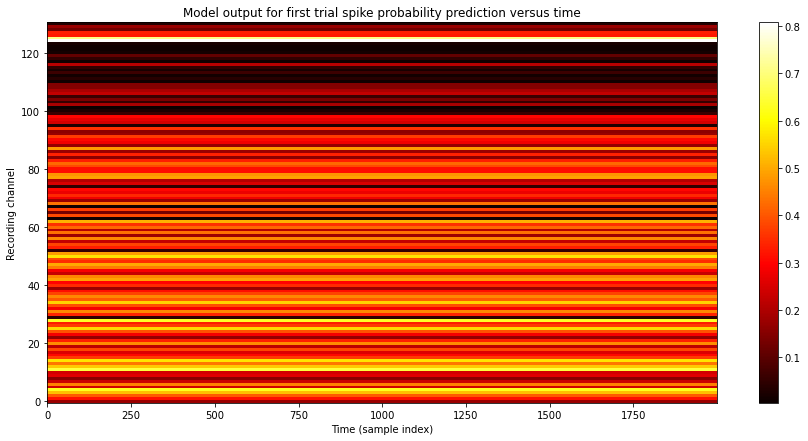

In [474]:
plt.figure(figsize=(15,7))
plt.imshow(nondynamic_rnn_m131_out[0].T, cmap='hot', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('Time (sample index)')
plt.ylabel('Recording channel')
plt.title('Model output for first trial spike probability prediction versus time')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/nondynam_rnn_m131_heatmap.png', dpi=300)
plt.show()

In [327]:
nondynamic_m131_nospike, nondynamic_m131_spike = calculate_avg_pred_prob_onestep_RNN(nondynamic_rnn_m131_randinit, indep_spikes)
print(nondynamic_m131_nospike)
print(nondynamic_m131_spike)

0.30797916650772095
0.4006016254425049


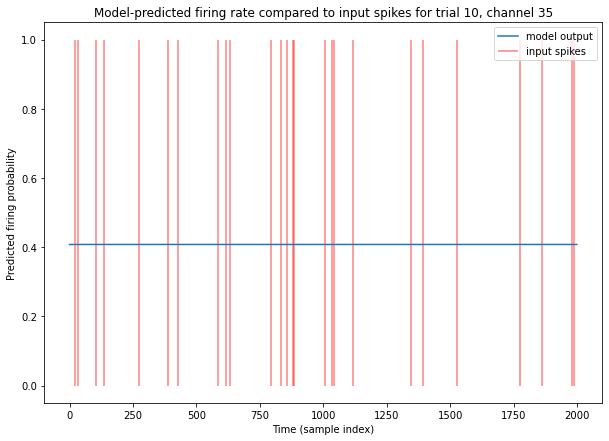

In [475]:
trial = 10
channel = 35

plt.figure(figsize=(10,7))
plt.plot(nondynamic_rnn_m131_out[trial, :, channel], label='model output')
plt.vlines(x=np.argwhere(indep_spikes[trial,channel,:]), ymin=0.0, ymax=1.0, colors='r', alpha=0.5, label='input spikes')
plt.xlabel('Time (sample index)')
plt.ylabel('Predicted firing probability')
plt.title(f'Model-predicted firing rate compared to input spikes for trial {trial}, channel {channel}')
plt.legend()
plt.savefig('../../Summer/Data 2050/Practicum report/figures/nondynam_rnn_m131_channel_example.png', dpi=300)

plt.show()

***Saving the model:***

In [352]:
# torch.save(nondynamic_rnn_m131_randinit, 'nondynamic_input_rnn_m131.pt')

----

# Going to run the three sets of data through a reduced-dimension bottleneck model

... and going to apply the original initialization and training procedures to get a view of the capacity of our model architecture to successfully perform our original conception of the task under the different data conditions.

## M=10

## Dynamical synthetic data

In [370]:
synthetic_rnn_m10 = create_and_train_rnn_model(10, sorted_synthetic_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.430
[1,  2000] loss: 0.227
[1,  3000] loss: 0.171
[1,  4000] loss: 0.145
[1,  5000] loss: 0.120
[1,  6000] loss: 0.109
[1,  7000] loss: 0.098
[1,  8000] loss: 0.092
[1,  9000] loss: 0.086
[2,  1000] loss: 0.078
[2,  2000] loss: 0.073
[2,  3000] loss: 0.070
[2,  4000] loss: 0.068
[2,  5000] loss: 0.063
[2,  6000] loss: 0.060
[2,  7000] loss: 0.059
[2,  8000] loss: 0.057
[2,  9000] loss: 0.057
[3,  1000] loss: 0.051
[3,  2000] loss: 0.051
[3,  3000] loss: 0.049
[3,  4000] loss: 0.048
[3,  5000] loss: 0.048
[3,  6000] loss: 0.046
[3,  7000] loss: 0.045
[3,  8000] loss: 0.045
[3,  9000] loss: 0.044
[4,  1000] loss: 0.044
[4,  2000] loss: 0.043
[4,  3000] loss: 0.041
[4,  4000] loss: 0.040
[4,  5000] loss: 0.042
[4,  6000] loss: 0.039
[4,  7000] loss: 0.040
[4,  8000] loss: 0.039
[4,  9000] loss: 0.040
[5,  1000] loss: 0.039
[5,  2000] loss: 0.039
[5,  3000] loss: 0.038
[5,  4000] loss: 0.038
[5,  5000] loss: 0.039
[5,

In [371]:
dynam_rnn_m10_max_var, dynam_rnn_m10_out = is_output_constant(synthetic_rnn_m10, sorted_spikes)
print(dynam_rnn_m10_max_var)

0.06711345911026001


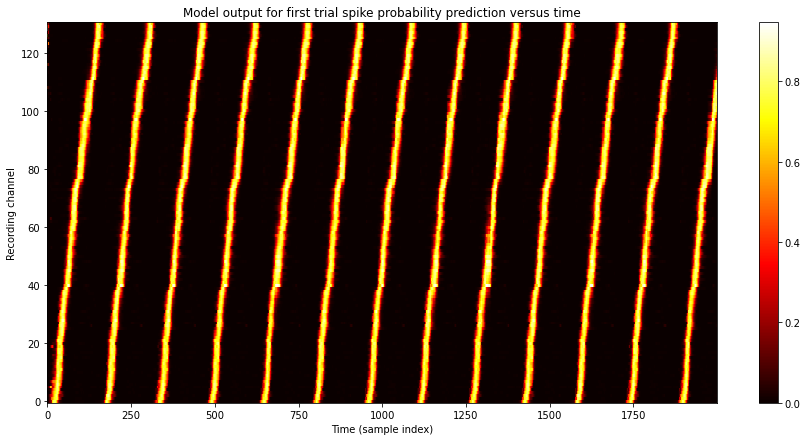

In [450]:
plt.figure(figsize=(15,7))
plt.imshow(dynam_rnn_m10_out[0].T, cmap='hot', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('Time (sample index)')
plt.ylabel('Recording channel')
plt.title('Model output for first trial spike probability prediction versus time')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/dynam_rnn_m10_heatmap.png', dpi=300)
plt.show()

In [373]:
dynamic_m10_nospike, dynamic_m10_spike = calculate_avg_pred_prob_onestep_RNN(synthetic_rnn_m10, sorted_spikes)
print(dynamic_m10_nospike)
print(dynamic_m10_spike)

0.1515432596206665
0.6737357378005981


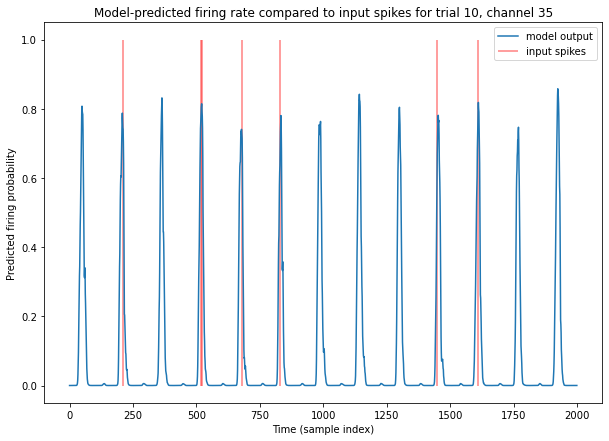

In [452]:
trial = 10
channel = 35

plt.figure(figsize=(10,7))
plt.plot(dynam_rnn_m10_out[trial, :, channel], label='model output')
plt.vlines(x=np.argwhere(sorted_spikes[trial,channel,:]), ymin=0.0, ymax=1.0, colors='r', alpha=0.5, label='input spikes')
plt.xlabel('Time (sample index)')
plt.ylabel('Predicted firing probability')
plt.title(f'Model-predicted firing rate compared to input spikes for trial {trial}, channel {channel}')
plt.legend()
plt.savefig('../../Summer/Data 2050/Practicum report/figures/dynam_rnn_m10_example_channel.png', dpi=300)
plt.show()

In [396]:
# torch.save(synthetic_rnn_m10, 'dynamic_input_rnn_m10.pt')

/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RNN_nextstep. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon l

## Non-dynamical synthetic data

In [379]:
nondynamic_rnn_m10 = create_and_train_rnn_model(10, indep_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.422
[1,  2000] loss: 0.217
[1,  3000] loss: 0.157
[1,  4000] loss: 0.128
[1,  5000] loss: 0.110
[1,  6000] loss: 0.099
[1,  7000] loss: 0.090
[1,  8000] loss: 0.081
[1,  9000] loss: 0.076
[2,  1000] loss: 0.068
[2,  2000] loss: 0.065
[2,  3000] loss: 0.061
[2,  4000] loss: 0.058
[2,  5000] loss: 0.058
[2,  6000] loss: 0.055
[2,  7000] loss: 0.053
[2,  8000] loss: 0.052
[2,  9000] loss: 0.049
[3,  1000] loss: 0.048
[3,  2000] loss: 0.045
[3,  3000] loss: 0.046
[3,  4000] loss: 0.046
[3,  5000] loss: 0.045
[3,  6000] loss: 0.044
[3,  7000] loss: 0.042
[3,  8000] loss: 0.044
[3,  9000] loss: 0.041
[4,  1000] loss: 0.042
[4,  2000] loss: 0.041
[4,  3000] loss: 0.040
[4,  4000] loss: 0.042
[4,  5000] loss: 0.039
[4,  6000] loss: 0.040
[4,  7000] loss: 0.040
[4,  8000] loss: 0.040
[4,  9000] loss: 0.039
[5,  1000] loss: 0.038
[5,  2000] loss: 0.040
[5,  3000] loss: 0.039
[5,  4000] loss: 0.038
[5,  5000] loss: 0.039
[5,

In [380]:
nondynamic_rnn_m10_max_var, nondynamic_rnn_m10_out = is_output_constant(nondynamic_rnn_m10, indep_spikes)
print(nondynamic_rnn_m10_max_var)

0.00032453815219923854


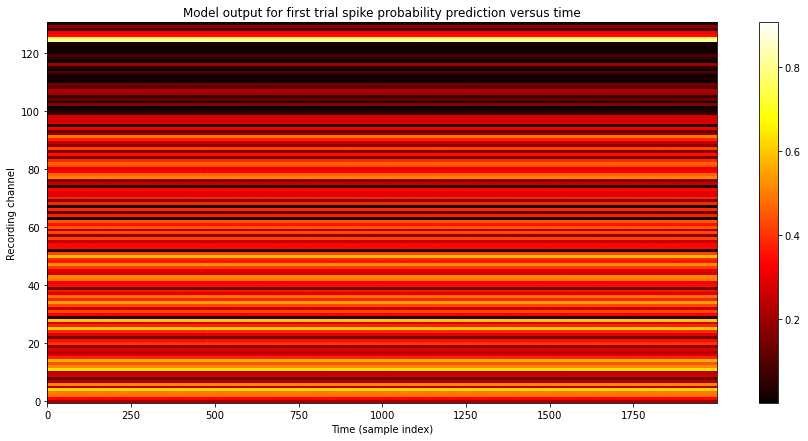

In [472]:
plt.figure(figsize=(15,7))
plt.imshow(nondynamic_rnn_m10_out[0].T, cmap='hot', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('Time (sample index)')
plt.ylabel('Recording channel')
plt.title('Model output for first trial spike probability prediction versus time')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/nondynam_rnn_m10_heatmap.png', dpi=300)
plt.show()

In [382]:
nondynamic_m10_nospike, nondynamic_m10_spike = calculate_avg_pred_prob_onestep_RNN(nondynamic_rnn_m10, indep_spikes)
print(nondynamic_m10_nospike)
print(nondynamic_m10_spike)

0.30690693855285645
0.3984944522380829


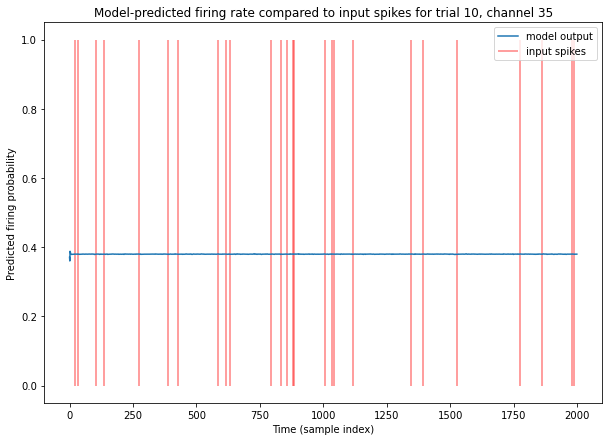

In [473]:
trial = 10
channel = 35

plt.figure(figsize=(10,7))
plt.plot(nondynamic_rnn_m10_out[trial, :, channel], label='model output')
plt.vlines(x=np.argwhere(indep_spikes[trial,channel,:]), ymin=0.0, ymax=1.0, colors='r', alpha=0.5, label='input spikes')
plt.xlabel('Time (sample index)')
plt.ylabel('Predicted firing probability')
plt.title(f'Model-predicted firing rate compared to input spikes for trial {trial}, channel {channel}')
plt.legend()
plt.savefig('../../Summer/Data 2050/Practicum report/figures/nondynam_rnn_m10_example_channel.png', dpi=300)
plt.show()

In [397]:
# torch.save(nondynamic_rnn_m10, 'nondynamic_input_rnn_m10.pt')

## The original experimental data

In [390]:
empirical_rnn_m10 = create_and_train_rnn_model(10, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.410
[1,  2000] loss: 0.214
[1,  3000] loss: 0.164
[1,  4000] loss: 0.139
[1,  5000] loss: 0.120
[1,  6000] loss: 0.107
[1,  7000] loss: 0.099
[1,  8000] loss: 0.091
[1,  9000] loss: 0.085
[2,  1000] loss: 0.076
[2,  2000] loss: 0.070
[2,  3000] loss: 0.069
[2,  4000] loss: 0.063
[2,  5000] loss: 0.061
[2,  6000] loss: 0.059
[2,  7000] loss: 0.055
[2,  8000] loss: 0.055
[2,  9000] loss: 0.053
[3,  1000] loss: 0.049
[3,  2000] loss: 0.050
[3,  3000] loss: 0.046
[3,  4000] loss: 0.048
[3,  5000] loss: 0.047
[3,  6000] loss: 0.044
[3,  7000] loss: 0.044
[3,  8000] loss: 0.046
[3,  9000] loss: 0.042
[4,  1000] loss: 0.042
[4,  2000] loss: 0.044
[4,  3000] loss: 0.040
[4,  4000] loss: 0.040
[4,  5000] loss: 0.041
[4,  6000] loss: 0.040
[4,  7000] loss: 0.039
[4,  8000] loss: 0.037
[4,  9000] loss: 0.040
[5,  1000] loss: 0.037
[5,  2000] loss: 0.039
[5,  3000] loss: 0.038
[5,  4000] loss: 0.037
[5,  5000] loss: 0.039
[5,

In [391]:
empirical_rnn_m10_max_var, empirical_rnn_m10_out = is_output_constant(empirical_rnn_m10, spikes)
print(empirical_rnn_m10_max_var)

0.0006006738403812051


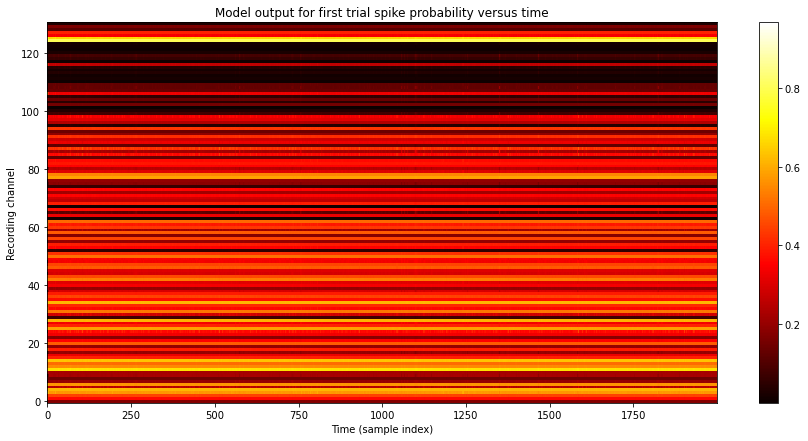

In [448]:
plt.figure(figsize=(15,7))
plt.imshow(empirical_rnn_m10_out[0].T, cmap='hot', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('Time (sample index)')
plt.ylabel('Recording channel')
plt.title('Model output for first trial spike probability versus time')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/empirical_rnn_m10_heatmap.png', dpi=300)
plt.show()

In [393]:
empirical_m10_nospike, empirical_m10_spike = calculate_avg_pred_prob_onestep_RNN(empirical_rnn_m10, spikes)
print(empirical_m10_nospike)
print(empirical_m10_spike)

0.31634920835494995
0.4093056619167328


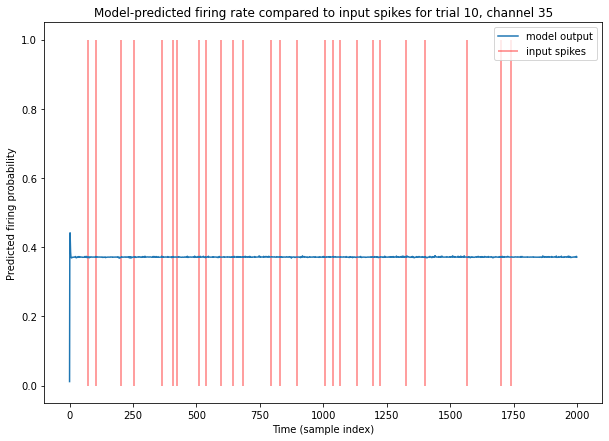

In [447]:
trial = 10
channel = 35

plt.figure(figsize=(10,7))
plt.plot(empirical_rnn_m10_out[trial, :, channel], label='model output')
plt.vlines(x=np.argwhere(spikes[trial,channel,:]), ymin=0.0, ymax=1.0, colors='r', alpha=0.5, label='input spikes')
plt.xlabel('Time (sample index)')
plt.ylabel('Predicted firing probability')
plt.title(f'Model-predicted firing rate compared to input spikes for trial {trial}, channel {channel}')
plt.legend()
plt.savefig('../../Summer/Data 2050/Practicum report/figures/empirical_rnn_m10_channel_example.png', dpi=300)
plt.show()

In [398]:
# torch.save(empirical_rnn_m10, 'empirical_input_rnn_m10.pt')

# Rerunning earlier experiments to create plots for the report

## M=20 RNN with the empirical data

In [405]:
empirical_rnn_m20 = create_and_train_rnn_model(20, seq_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.383
[1,  2000] loss: 0.171
[1,  3000] loss: 0.124
[1,  4000] loss: 0.103
[1,  5000] loss: 0.088
[1,  6000] loss: 0.075
[1,  7000] loss: 0.067
[1,  8000] loss: 0.062
[1,  9000] loss: 0.057
[2,  1000] loss: 0.049
[2,  2000] loss: 0.046
[2,  3000] loss: 0.045
[2,  4000] loss: 0.042
[2,  5000] loss: 0.040
[2,  6000] loss: 0.039
[2,  7000] loss: 0.037
[2,  8000] loss: 0.037
[2,  9000] loss: 0.035
[3,  1000] loss: 0.034
[3,  2000] loss: 0.032
[3,  3000] loss: 0.032
[3,  4000] loss: 0.031
[3,  5000] loss: 0.031
[3,  6000] loss: 0.031
[3,  7000] loss: 0.031
[3,  8000] loss: 0.030
[3,  9000] loss: 0.030
[4,  1000] loss: 0.028
[4,  2000] loss: 0.027
[4,  3000] loss: 0.029
[4,  4000] loss: 0.028
[4,  5000] loss: 0.027
[4,  6000] loss: 0.026
[4,  7000] loss: 0.026
[4,  8000] loss: 0.025
[4,  9000] loss: 0.027
[5,  1000] loss: 0.025
[5,  2000] loss: 0.025
[5,  3000] loss: 0.025
[5,  4000] loss: 0.025
[5,  5000] loss: 0.024
[5,

In [406]:
empirical_rnn_m20_max_var, empirical_rnn_m20_out = is_output_constant(empirical_rnn_m20, spikes)
print(empirical_rnn_m20_max_var)

0.020925095304846764


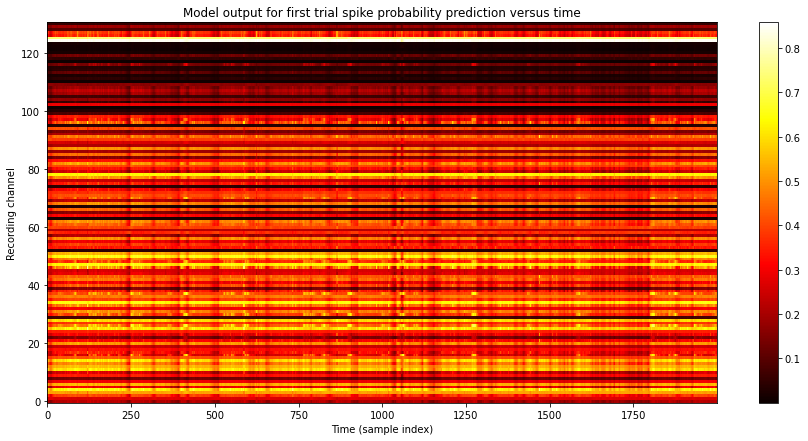

In [446]:
plt.figure(figsize=(15,7))
plt.imshow(empirical_rnn_m20_out[0].T, cmap='hot', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('Time (sample index)')
plt.ylabel('Recording channel')
plt.title('Model output for first trial spike probability prediction versus time')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/empirical_rnn_m20_heatmap.png', dpi=300)
plt.show()

In [408]:
empirical_m20_nospike, empirical_m20_spike = calculate_avg_pred_prob_onestep_RNN(empirical_rnn_m20, spikes)
print(empirical_m20_nospike)
print(empirical_m20_spike)

0.3077760338783264
0.41523879766464233


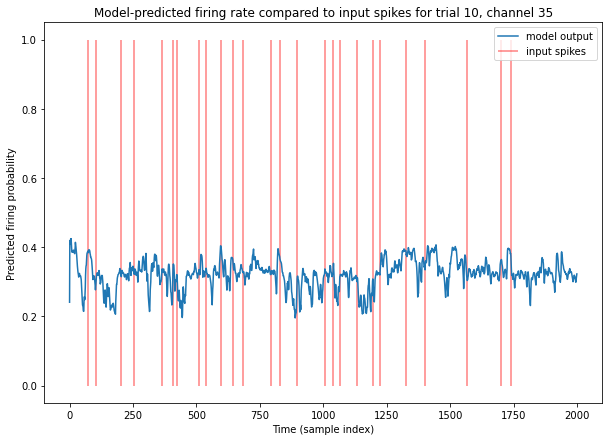

In [445]:
trial = 10
channel = 35

plt.figure(figsize=(10,7))
plt.plot(empirical_rnn_m20_out[trial, :, channel], label='model output')
plt.vlines(x=np.argwhere(spikes[trial,channel,:]), ymin=0.0, ymax=1.0, colors='r', alpha=0.5, label='input spikes')
plt.xlabel('Time (sample index)')
plt.ylabel('Predicted firing probability')
plt.title(f'Model-predicted firing rate compared to input spikes for trial {trial}, channel {channel}')
plt.legend()
plt.savefig('../../Summer/Data 2050/Practicum report/figures/empirical_rnn_m20_channel_example.png', dpi=300)
plt.show()

# More dynamical data experiments – new versions of the dataset with $\sigma = 20, 100$ bins

## $\sigma = 20$ bins dataset

In [455]:
with open('../pytorch_experiments/binary_spike_matrix_data/SYNTHETIC_SORTED_sigma20_spike_mtx__09_08_40.npy', 'rb') as f:
    sorted_spikes_s20 = np.load(f, allow_pickle=True)

In [456]:
sorted_spikes_s20.shape

(487, 131, 2001)

***The sorted synthetic data should show the cascading probability functions across all channels versus time:***

Getting the channel,time coordinates of all the spikes in the first trial

In [459]:
one_coords = list(zip(*list(np.argwhere(sorted_spikes_s20[0]))))

In [460]:
max(one_coords[0])

130

***Plotting the spikes per channel versus time for the first trial – this confirms the banded structure of the units in this set of synthetic data***

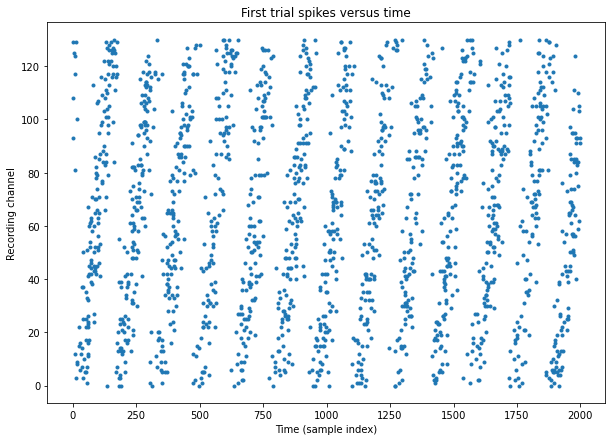

In [462]:
plt.figure(figsize=(10,7))
plt.scatter(x = one_coords[1], y = one_coords[0], marker='.')
plt.xlabel('Time (sample index)')
plt.ylabel('Recording channel')
plt.title('First trial spikes versus time')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/dyn_data_spikes_sigma20.png', dpi=300)
plt.show()

In [463]:
dynamic_s20_dataset = SequenceDataset(torch.from_numpy(sorted_spikes_s20).float())

dynamic_s20_loader = DataLoader(dynamic_s20_dataset, batch_size=1, shuffle=True)

In [464]:
synthetic_rnn_m10_sig20 = create_and_train_rnn_model(10, dynamic_s20_loader)

======= BEGINNING FEED-FORWARD MODEL TRAINING =======
[1,  1000] loss: 0.430
[1,  2000] loss: 0.207
[1,  3000] loss: 0.162
[1,  4000] loss: 0.131
[1,  5000] loss: 0.115
[1,  6000] loss: 0.101
[1,  7000] loss: 0.095
[1,  8000] loss: 0.085
[1,  9000] loss: 0.081
[2,  1000] loss: 0.071
[2,  2000] loss: 0.069
[2,  3000] loss: 0.066
[2,  4000] loss: 0.061
[2,  5000] loss: 0.060
[2,  6000] loss: 0.058
[2,  7000] loss: 0.056
[2,  8000] loss: 0.055
[2,  9000] loss: 0.054
[3,  1000] loss: 0.049
[3,  2000] loss: 0.048
[3,  3000] loss: 0.049
[3,  4000] loss: 0.047
[3,  5000] loss: 0.046
[3,  6000] loss: 0.043
[3,  7000] loss: 0.043
[3,  8000] loss: 0.042
[3,  9000] loss: 0.043
[4,  1000] loss: 0.040
[4,  2000] loss: 0.042
[4,  3000] loss: 0.040
[4,  4000] loss: 0.040
[4,  5000] loss: 0.039
[4,  6000] loss: 0.039
[4,  7000] loss: 0.041
[4,  8000] loss: 0.038
[4,  9000] loss: 0.038
[5,  1000] loss: 0.037
[5,  2000] loss: 0.036
[5,  3000] loss: 0.038
[5,  4000] loss: 0.037
[5,  5000] loss: 0.036
[5,

In [465]:
dynam_rnn_m10_s20_max_var, dynam_rnn_m10_s20_out = is_output_constant(synthetic_rnn_m10_sig20, sorted_spikes_s20)
print(dynam_rnn_m10_s20_max_var)

0.045454032719135284


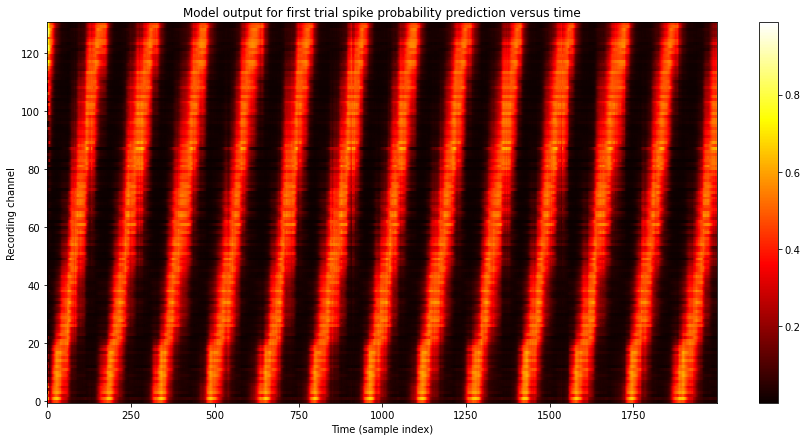

In [466]:
plt.figure(figsize=(15,7))
plt.imshow(dynam_rnn_m10_s20_out[0].T, cmap='hot', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('Time (sample index)')
plt.ylabel('Recording channel')
plt.title('Model output for first trial spike probability prediction versus time')
plt.savefig('../../Summer/Data 2050/Practicum report/figures/dynam_rnn_m10_s20_heatmap.png', dpi=300)
plt.show()

In [467]:
dynamic_m10_s20_nospike, dynamic_m10_s20_spike = calculate_avg_pred_prob_onestep_RNN(synthetic_rnn_m10_sig20, sorted_spikes_s20)
print(dynamic_m10_s20_nospike)
print(dynamic_m10_s20_spike)

0.21839630603790283
0.3579074740409851


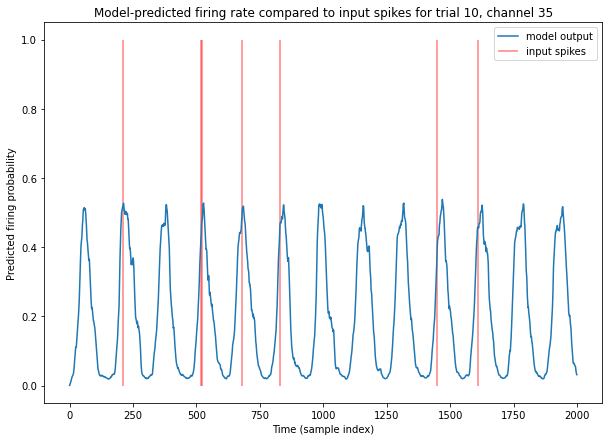

In [468]:
trial = 10
channel = 35

plt.figure(figsize=(10,7))
plt.plot(dynam_rnn_m10_s20_out[trial, :, channel], label='model output')
plt.vlines(x=np.argwhere(sorted_spikes[trial,channel,:]), ymin=0.0, ymax=1.0, colors='r', alpha=0.5, label='input spikes')
plt.xlabel('Time (sample index)')
plt.ylabel('Predicted firing probability')
plt.title(f'Model-predicted firing rate compared to input spikes for trial {trial}, channel {channel}')
plt.legend()
plt.savefig('../../Summer/Data 2050/Practicum report/figures/dynam_rnn_m10_s20_example_channel.png', dpi=300)
plt.show()